In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from torchcontrol.arch_cpugpu import HDNN, HDNN_Observer
from torchcontrol.utils import genpoints

In [2]:
if torch.cuda.is_available(): device = torch.device('cuda')

# Duffing stuff

In [11]:
from matplotlib import animation, rc
import seaborn as sbs
from scipy.integrate import odeint, quad
rc('animation', html='html5')

In [12]:
# The potential and its first derivative, as callables.
V = lambda x: 0.5 * x**2 * (0.5 * x**2 - 1)
dVdx = lambda x: x**3 - x

In [13]:
# The potential energy function on a grid of x-points.
xgrid = np.linspace(-1.5, 1.5, 100)
Vgrid = V(xgrid)

Text(0, 0.5, '$V(x)$')

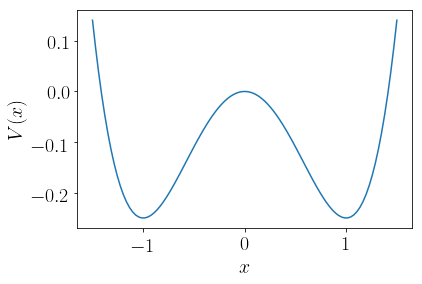

In [14]:
plt.plot(xgrid, Vgrid)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

In [15]:
def deriv(X, t, gamma, delta, omega):
    """Return the derivatives dx/dt and d2x/dt2."""

    x, xdot = X
    xdotdot = -dVdx(x) -delta * xdot + gamma * np.cos(omega*t)
    return xdot, xdotdot

In [52]:
def solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega):
    """Solve the Duffing equation for parameters gamma, delta, omega.

    Find the numerical solution to the Duffing equation using a suitable
    time grid: tmax is the maximum time (s) to integrate to; t_trans is
    the initial time period of transient behaviour until the solution
    settles down (if it does) to some kind of periodic motion (these data
    points are dropped) and dt_per_period is the number of time samples
    (of duration dt) to include per period of the driving motion (frequency
    omega).

    Returns the time grid, t (after t_trans), position, x, and velocity,
    xdot, dt, and step, the number of array points per period of the driving
    motion.

    """
    # Time point spacings and the time grid

    period = 2*np.pi/omega
    dt = 2*np.pi/omega / dt_per_period
    step = int(period / dt)
    t = np.arange(0, tmax, dt)
    # Initial conditions: x, xdot
    X0 = [x0, v0]
    X = odeint(deriv, X0, t, args=(gamma, delta, omega))
    idx = int(t_trans / dt)
    return t[idx:], X[idx:], dt, step

In [53]:
# Set up the motion for a oscillator with initial position
# x0 and initially at rest.
x0, v0 = 0, 0
tmax, t_trans = 600, 300
omega = 1.4
gamma, delta = 0.39, 0.1
dt_per_period = 40

# Solve the equation of motion.
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega)
x, xdot = X.T

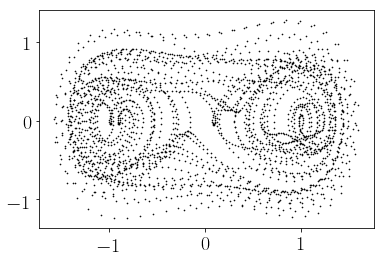

In [54]:
plt.scatter(x, xdot, s=0.4, color='black')

In [56]:
x = torch.Tensor(x).to(device)
xdot = torch.Tensor(xdot).to(device)

In [57]:
labels = torch.stack((x, xdot), 0)[:, 1:]

In [58]:
labels.shape

torch.Size([2, 2674])

# Poincare' section 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RuntimeError: Requested MovieWriter (ffmpeg) not available

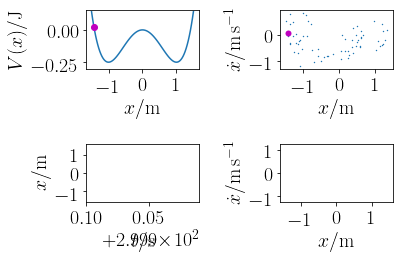

In [55]:
# The animation
fig, ax = plt.subplots(nrows=2,ncols=2)
ax1 = ax[0,0]
ax1.plot(xgrid, Vgrid)
ax1.set_ylim(-0.3, 0.15)
ln1, = ax1.plot([], [], 'mo')
ax1.set_xlabel(r'$x / \mathrm{m}$')
ax1.set_ylabel(r'$V(x) / \mathrm{J}$')

# Position as a function of time
ax2 = ax[1,0]
ax2.set_xlabel(r'$t / \mathrm{s}$')
ax2.set_ylabel(r'$x / \mathrm{m}$')
ln2, = ax2.plot(t[:100], x[:100])
ax2.set_ylim(np.min(x), np.max(x))

# Phase space plot
ax3 = ax[1,1]
ax3.set_xlabel(r'$x / \mathrm{m}$')
ax3.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ln3, = ax3.plot([], [])
ax3.set_xlim(np.min(x), np.max(x))
ax3.set_ylim(np.min(xdot), np.max(xdot))

# Poincaré section plot
ax4 = ax[0,1]
ax4.set_xlabel(r'$x / \mathrm{m}$')
ax4.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ax4.scatter(x[::pstep], xdot[::pstep], s=2, lw=0, c=sbs.color_palette()[0])
scat1 = ax4.scatter([x0], [v0], lw=0, c='m')
plt.tight_layout()

def animate(i):
    """Update the image for iteration i of the Matplotlib animation."""

    ln1.set_data(x[i], V(x[i]))
    ln2.set_data(t[:i+1], x[:i+1])
    ax2.set_xlim(t_trans, t[i])
    ln3.set_data(x[:i+1], xdot[:i+1])
    if not i % pstep:
        scat1.set_offsets(X[i])
    return

anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=1)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

anim.save('duffing.mp4', writer=writer)

In [64]:
class duffingOscillator(nn.Module):
    def __init__(self, n, w, beta, gamma):
        super().__init__()
        self.J = createJ(n, w, beta, gamma)
    def forward(self, t, xi):
        return torch.matmul(self.J,xi).to(device)

In [65]:
def createJ(n, w, beta, gamma):
    I = torch.eye(n//2)
    M1 = (-w*2-beta)*torch.eye(n//2)
    M2 = (-gamma)*torch.eye(n//2)
    O = torch.zeros((n//2,n//2))
    return torch.cat(((torch.cat((O,I),1)),(torch.cat((M1,M2),1))),0).to(device)

In [66]:
A = createJ(2,1,1,1)
B = createJ(2,1,1,1)
A, B

(tensor([[ 0.,  1.],
         [-3., -1.]], device='cuda:0'), tensor([[ 0.,  1.],
         [-3., -1.]], device='cuda:0'))

In [67]:
osc = duffingOscillator(2,1,0,7.5)
t = torch.linspace(0,1000,200)
xi0 = torch.Tensor([1,0.5]).to(device)
func = osc.forward
sol = odeint(func,xi0,t)

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

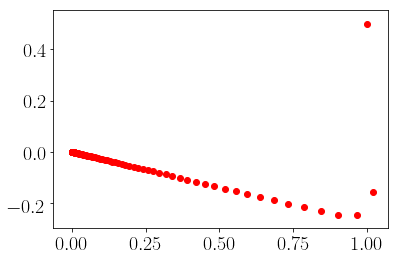

In [63]:
for p in range(len(sol)):
    plt.scatter(sol[p][0].cpu().numpy(),sol[p][1].cpu().numpy(), color='r')

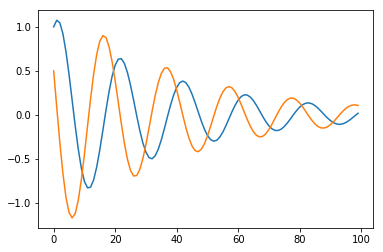

In [8]:
plt.plot(sol.cpu().numpy())

## Create dataset

In [9]:
osc = duffingOscillator(2,0.5,0.5,0.2)
t = torch.linspace(0,7,100)
xi0 = torch.Tensor([1,0.5]).to(device)
func = osc.forward
sol = odeint(func,xi0,t)

In [10]:
labels = sol[1:]

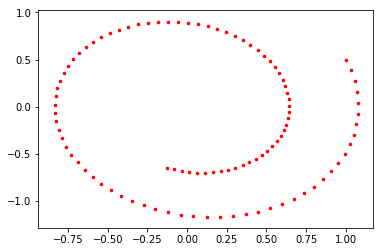

In [11]:
for p in range(len(sol)):
    plt.scatter(sol[p][0].cpu().numpy(),sol[p][1].cpu().numpy(), s=6.5, color='r')

## Learning a trajectory with HDDNs (access to full state, RNN test)

In [59]:
labels = torch.transpose(labels, 0, 1)

In [60]:
obs = HDNN_Observer([2,36,2],'MLP',[1,2,0],1, None, False, 'cpu')

In [61]:
x0 = torch.Tensor([0,0]).to(device)
x0 = x0.view(1,2)

In [62]:
t = obs.observe(x0, labels, epoch=1, ode_t=5, ode_step=2, loss_record_interval=100)

odeint iter: 10 
odeint iter: 20 
odeint iter: 30 
odeint iter: 40 
odeint iter: 50 
odeint iter: 60 
odeint iter: 70 
odeint iter: 80 
odeint iter: 90 
odeint iter: 100 
odeint iter: 110 
odeint iter: 120 
odeint iter: 130 
odeint iter: 140 
odeint iter: 150 
odeint iter: 160 
odeint iter: 170 
odeint iter: 180 
odeint iter: 190 
odeint iter: 200 
odeint iter: 210 
odeint iter: 220 
odeint iter: 230 
odeint iter: 240 
odeint iter: 250 
odeint iter: 260 
odeint iter: 270 
odeint iter: 280 
odeint iter: 290 
odeint iter: 300 
odeint iter: 310 
odeint iter: 320 
odeint iter: 330 
odeint iter: 340 
odeint iter: 350 
odeint iter: 360 
odeint iter: 370 
odeint iter: 380 
odeint iter: 390 
odeint iter: 400 
odeint iter: 410 
odeint iter: 420 
odeint iter: 430 
odeint iter: 440 
odeint iter: 450 
odeint iter: 460 
odeint iter: 470 
odeint iter: 480 
odeint iter: 490 
odeint iter: 500 
odeint iter: 510 
odeint iter: 520 
odeint iter: 530 
odeint iter: 540 
odeint iter: 550 
odeint iter: 560 
o

odeint iter: 4400 
odeint iter: 4410 
odeint iter: 4420 
odeint iter: 4430 
odeint iter: 4440 
odeint iter: 4450 
odeint iter: 4460 
odeint iter: 4470 
odeint iter: 4480 
odeint iter: 4490 
odeint iter: 4500 
odeint iter: 4510 
odeint iter: 4520 
odeint iter: 4530 
odeint iter: 4540 
odeint iter: 4550 
odeint iter: 4560 
odeint iter: 4570 
odeint iter: 4580 
odeint iter: 4590 
odeint iter: 4600 
odeint iter: 4610 
odeint iter: 4620 
odeint iter: 4630 
odeint iter: 4640 
odeint iter: 4650 
odeint iter: 4660 
odeint iter: 4670 
odeint iter: 4680 
odeint iter: 4690 
odeint iter: 4700 
odeint iter: 4710 
odeint iter: 4720 
odeint iter: 4730 
odeint iter: 4740 
odeint iter: 4750 
odeint iter: 4760 
odeint iter: 4770 
odeint iter: 4780 
odeint iter: 4790 
odeint iter: 4800 
odeint iter: 4810 
odeint iter: 4820 
odeint iter: 4830 
odeint iter: 4840 
odeint iter: 4850 
odeint iter: 4860 
odeint iter: 4870 
odeint iter: 4880 
odeint iter: 4890 
odeint iter: 4900 
odeint iter: 4910 
odeint iter:

odeint iter: 8740 
odeint iter: 8750 
odeint iter: 8760 
odeint iter: 8770 
odeint iter: 8780 
odeint iter: 8790 
odeint iter: 8800 
odeint iter: 8810 
odeint iter: 8820 
odeint iter: 8830 
odeint iter: 8840 
odeint iter: 8850 
odeint iter: 8860 
odeint iter: 8870 
odeint iter: 8880 
odeint iter: 8890 
odeint iter: 8900 
odeint iter: 8910 
odeint iter: 8920 
odeint iter: 8930 
odeint iter: 8940 
odeint iter: 8950 
odeint iter: 8960 
odeint iter: 8970 
odeint iter: 8980 
odeint iter: 8990 
odeint iter: 9000 
odeint iter: 9010 
odeint iter: 9020 
odeint iter: 9030 
odeint iter: 9040 
odeint iter: 9050 
odeint iter: 9060 
odeint iter: 9070 
odeint iter: 9080 
odeint iter: 9090 
odeint iter: 9100 
odeint iter: 9110 
odeint iter: 9120 
odeint iter: 9130 
odeint iter: 9140 
odeint iter: 9150 
odeint iter: 9160 
odeint iter: 9170 
odeint iter: 9180 
odeint iter: 9190 
odeint iter: 9200 
odeint iter: 9210 
odeint iter: 9220 
odeint iter: 9230 
odeint iter: 9240 
odeint iter: 9250 
odeint iter:

odeint iter: 12900 
odeint iter: 12910 
odeint iter: 12920 
odeint iter: 12930 
odeint iter: 12940 
odeint iter: 12950 
odeint iter: 12960 
odeint iter: 12970 
odeint iter: 12980 
odeint iter: 12990 
odeint iter: 13000 
odeint iter: 13010 
odeint iter: 13020 
odeint iter: 13030 
odeint iter: 13040 
odeint iter: 13050 
odeint iter: 13060 
odeint iter: 13070 
odeint iter: 13080 
odeint iter: 13090 
odeint iter: 13100 
odeint iter: 13110 
odeint iter: 13120 
odeint iter: 13130 
odeint iter: 13140 
odeint iter: 13150 
odeint iter: 13160 
odeint iter: 13170 
odeint iter: 13180 
odeint iter: 13190 
odeint iter: 13200 
odeint iter: 13210 
odeint iter: 13220 
odeint iter: 13230 
odeint iter: 13240 
odeint iter: 13250 
odeint iter: 13260 
odeint iter: 13270 
odeint iter: 13280 
odeint iter: 13290 
odeint iter: 13300 
odeint iter: 13310 
odeint iter: 13320 
odeint iter: 13330 
odeint iter: 13340 
odeint iter: 13350 
odeint iter: 13360 
odeint iter: 13370 
odeint iter: 13380 
odeint iter: 13390 


odeint iter: 17010 
odeint iter: 17020 
odeint iter: 17030 
odeint iter: 17040 
odeint iter: 17050 
odeint iter: 17060 
odeint iter: 17070 
odeint iter: 17080 
odeint iter: 17090 
odeint iter: 17100 
odeint iter: 17110 
odeint iter: 17120 
odeint iter: 17130 
odeint iter: 17140 
odeint iter: 17150 
odeint iter: 17160 
odeint iter: 17170 
odeint iter: 17180 
odeint iter: 17190 
odeint iter: 17200 
odeint iter: 17210 
odeint iter: 17220 
odeint iter: 17230 
odeint iter: 17240 
odeint iter: 17250 
odeint iter: 17260 
odeint iter: 17270 
odeint iter: 17280 
odeint iter: 17290 
odeint iter: 17300 
odeint iter: 17310 
odeint iter: 17320 
odeint iter: 17330 
odeint iter: 17340 
odeint iter: 17350 
odeint iter: 17360 
odeint iter: 17370 
odeint iter: 17380 
odeint iter: 17390 
odeint iter: 17400 
odeint iter: 17410 
odeint iter: 17420 
odeint iter: 17430 
odeint iter: 17440 
odeint iter: 17450 
odeint iter: 17460 
odeint iter: 17470 
odeint iter: 17480 
odeint iter: 17490 
odeint iter: 17500 


odeint iter: 21110 
odeint iter: 21120 
odeint iter: 21130 
odeint iter: 21140 
odeint iter: 21150 
odeint iter: 21160 
odeint iter: 21170 
odeint iter: 21180 
odeint iter: 21190 
odeint iter: 21200 
odeint iter: 21210 
odeint iter: 21220 
odeint iter: 21230 
odeint iter: 21240 
odeint iter: 21250 
odeint iter: 21260 
odeint iter: 21270 
odeint iter: 21280 
odeint iter: 21290 
odeint iter: 21300 
odeint iter: 21310 
odeint iter: 21320 
odeint iter: 21330 
odeint iter: 21340 
odeint iter: 21350 
odeint iter: 21360 
odeint iter: 21370 
odeint iter: 21380 
odeint iter: 21390 
odeint iter: 21400 
odeint iter: 21410 
odeint iter: 21420 
odeint iter: 21430 
odeint iter: 21440 
odeint iter: 21450 
odeint iter: 21460 
odeint iter: 21470 
odeint iter: 21480 
odeint iter: 21490 
odeint iter: 21500 
odeint iter: 21510 
odeint iter: 21520 
odeint iter: 21530 
odeint iter: 21540 
odeint iter: 21550 
odeint iter: 21560 
odeint iter: 21570 
odeint iter: 21580 
odeint iter: 21590 
odeint iter: 21600 


odeint iter: 25240 
odeint iter: 25250 
odeint iter: 25260 
odeint iter: 25270 
odeint iter: 25280 
odeint iter: 25290 
odeint iter: 25300 
odeint iter: 25310 
odeint iter: 25320 
odeint iter: 25330 
odeint iter: 25340 
odeint iter: 25350 
odeint iter: 25360 
odeint iter: 25370 
odeint iter: 25380 
odeint iter: 25390 
odeint iter: 25400 
odeint iter: 25410 
odeint iter: 25420 
odeint iter: 25430 
odeint iter: 25440 
odeint iter: 25450 
odeint iter: 25460 
odeint iter: 25470 
odeint iter: 25480 
odeint iter: 25490 
odeint iter: 25500 
odeint iter: 25510 
odeint iter: 25520 
odeint iter: 25530 
odeint iter: 25540 
odeint iter: 25550 
odeint iter: 25560 
odeint iter: 25570 
odeint iter: 25580 
odeint iter: 25590 
odeint iter: 25600 
odeint iter: 25610 
odeint iter: 25620 
odeint iter: 25630 
odeint iter: 25640 
odeint iter: 25650 
odeint iter: 25660 
odeint iter: 25670 
odeint iter: 25680 
odeint iter: 25690 
odeint iter: 25700 
odeint iter: 25710 
odeint iter: 25720 
odeint iter: 25730 


odeint iter: 29350 
odeint iter: 29360 
odeint iter: 29370 
odeint iter: 29380 
odeint iter: 29390 
odeint iter: 29400 
odeint iter: 29410 
odeint iter: 29420 
odeint iter: 29430 
odeint iter: 29440 
odeint iter: 29450 
odeint iter: 29460 
odeint iter: 29470 
odeint iter: 29480 
odeint iter: 29490 
odeint iter: 29500 
odeint iter: 29510 
odeint iter: 29520 
odeint iter: 29530 
odeint iter: 29540 
odeint iter: 29550 
odeint iter: 29560 
odeint iter: 29570 
odeint iter: 29580 
odeint iter: 29590 
odeint iter: 29600 
odeint iter: 29610 
odeint iter: 29620 
odeint iter: 29630 
odeint iter: 29640 
odeint iter: 29650 
odeint iter: 29660 
odeint iter: 29670 
odeint iter: 29680 
odeint iter: 29690 
odeint iter: 29700 
odeint iter: 29710 
odeint iter: 29720 
odeint iter: 29730 
odeint iter: 29740 
odeint iter: 29750 
odeint iter: 29760 
odeint iter: 29770 
odeint iter: 29780 
odeint iter: 29790 
odeint iter: 29800 
odeint iter: 29810 
odeint iter: 29820 
odeint iter: 29830 
odeint iter: 29840 


odeint iter: 33480 
odeint iter: 33490 
odeint iter: 33500 
odeint iter: 33510 
odeint iter: 33520 
odeint iter: 33530 
odeint iter: 33540 
odeint iter: 33550 
odeint iter: 33560 
odeint iter: 33570 
odeint iter: 33580 
odeint iter: 33590 
odeint iter: 33600 
odeint iter: 33610 
odeint iter: 33620 
odeint iter: 33630 
odeint iter: 33640 
odeint iter: 33650 
odeint iter: 33660 
odeint iter: 33670 
odeint iter: 33680 
odeint iter: 33690 
odeint iter: 33700 
odeint iter: 33710 
odeint iter: 33720 
odeint iter: 33730 
odeint iter: 33740 
odeint iter: 33750 
odeint iter: 33760 
odeint iter: 33770 
odeint iter: 33780 
odeint iter: 33790 
odeint iter: 33800 
odeint iter: 33810 
odeint iter: 33820 
odeint iter: 33830 
odeint iter: 33840 
odeint iter: 33850 
odeint iter: 33860 
odeint iter: 33870 
odeint iter: 33880 
odeint iter: 33890 
odeint iter: 33900 
odeint iter: 33910 
odeint iter: 33920 
odeint iter: 33930 
odeint iter: 33940 
odeint iter: 33950 
odeint iter: 33960 
odeint iter: 33970 


odeint iter: 37580 
odeint iter: 37590 
odeint iter: 37600 
odeint iter: 37610 
odeint iter: 37620 
odeint iter: 37630 
odeint iter: 37640 
odeint iter: 37650 
odeint iter: 37660 
odeint iter: 37670 
odeint iter: 37680 
odeint iter: 37690 
odeint iter: 37700 
odeint iter: 37710 
odeint iter: 37720 
odeint iter: 37730 
odeint iter: 37740 
odeint iter: 37750 
odeint iter: 37760 
odeint iter: 37770 
odeint iter: 37780 
odeint iter: 37790 
odeint iter: 37800 
odeint iter: 37810 
odeint iter: 37820 
odeint iter: 37830 
odeint iter: 37840 
odeint iter: 37850 
odeint iter: 37860 
odeint iter: 37870 
odeint iter: 37880 
odeint iter: 37890 
odeint iter: 37900 
odeint iter: 37910 
odeint iter: 37920 
odeint iter: 37930 
odeint iter: 37940 
odeint iter: 37950 
odeint iter: 37960 
odeint iter: 37970 
odeint iter: 37980 
odeint iter: 37990 
odeint iter: 38000 
odeint iter: 38010 
odeint iter: 38020 
odeint iter: 38030 
odeint iter: 38040 
odeint iter: 38050 
odeint iter: 38060 
odeint iter: 38070 


odeint iter: 41700 
odeint iter: 41710 
odeint iter: 41720 
odeint iter: 41730 
odeint iter: 41740 
odeint iter: 41750 
odeint iter: 41760 
odeint iter: 41770 
odeint iter: 41780 
odeint iter: 41790 
odeint iter: 41800 
odeint iter: 41810 
odeint iter: 41820 
odeint iter: 41830 
odeint iter: 41840 
odeint iter: 41850 
odeint iter: 41860 
odeint iter: 41870 
odeint iter: 41880 
odeint iter: 41890 
odeint iter: 41900 
odeint iter: 41910 
odeint iter: 41920 
odeint iter: 41930 
odeint iter: 41940 
odeint iter: 41950 
odeint iter: 41960 
odeint iter: 41970 
odeint iter: 41980 
odeint iter: 41990 
odeint iter: 42000 
odeint iter: 42010 
odeint iter: 42020 
odeint iter: 42030 
odeint iter: 42040 
odeint iter: 42050 
odeint iter: 42060 
odeint iter: 42070 
odeint iter: 42080 
odeint iter: 42090 
odeint iter: 42100 
odeint iter: 42110 
odeint iter: 42120 
odeint iter: 42130 
odeint iter: 42140 
odeint iter: 42150 
odeint iter: 42160 
odeint iter: 42170 
odeint iter: 42180 
odeint iter: 42190 


odeint iter: 45830 
odeint iter: 45840 
odeint iter: 45850 
odeint iter: 45860 
odeint iter: 45870 
odeint iter: 45880 
odeint iter: 45890 
odeint iter: 45900 
odeint iter: 45910 
odeint iter: 45920 
odeint iter: 45930 
odeint iter: 45940 
odeint iter: 45950 
odeint iter: 45960 
odeint iter: 45970 
odeint iter: 45980 
odeint iter: 45990 
odeint iter: 46000 
odeint iter: 46010 
odeint iter: 46020 
odeint iter: 46030 
odeint iter: 46040 
odeint iter: 46050 
odeint iter: 46060 
odeint iter: 46070 
odeint iter: 46080 
odeint iter: 46090 
odeint iter: 46100 
odeint iter: 46110 
odeint iter: 46120 
odeint iter: 46130 
odeint iter: 46140 
odeint iter: 46150 
odeint iter: 46160 
odeint iter: 46170 
odeint iter: 46180 
odeint iter: 46190 
odeint iter: 46200 
odeint iter: 46210 
odeint iter: 46220 
odeint iter: 46230 
odeint iter: 46240 
odeint iter: 46250 
odeint iter: 46260 
odeint iter: 46270 
odeint iter: 46280 
odeint iter: 46290 
odeint iter: 46300 
odeint iter: 46310 
odeint iter: 46320 


odeint iter: 49930 
odeint iter: 49940 
odeint iter: 49950 
odeint iter: 49960 
odeint iter: 49970 
odeint iter: 49980 
odeint iter: 49990 
odeint iter: 50000 
odeint iter: 50010 
odeint iter: 50020 
odeint iter: 50030 
odeint iter: 50040 
odeint iter: 50050 
odeint iter: 50060 
odeint iter: 50070 
odeint iter: 50080 
odeint iter: 50090 
odeint iter: 50100 
odeint iter: 50110 
odeint iter: 50120 
odeint iter: 50130 
odeint iter: 50140 
odeint iter: 50150 
odeint iter: 50160 
odeint iter: 50170 
odeint iter: 50180 
odeint iter: 50190 
odeint iter: 50200 
odeint iter: 50210 
odeint iter: 50220 
odeint iter: 50230 
odeint iter: 50240 
odeint iter: 50250 
odeint iter: 50260 
odeint iter: 50270 
odeint iter: 50280 
odeint iter: 50290 
odeint iter: 50300 
odeint iter: 50310 
odeint iter: 50320 
odeint iter: 50330 
odeint iter: 50340 
odeint iter: 50350 
odeint iter: 50360 
odeint iter: 50370 
odeint iter: 50380 
odeint iter: 50390 
odeint iter: 50400 
odeint iter: 50410 
odeint iter: 50420 


odeint iter: 54070 
odeint iter: 54080 
odeint iter: 54090 
odeint iter: 54100 
odeint iter: 54110 
odeint iter: 54120 
odeint iter: 54130 
odeint iter: 54140 
odeint iter: 54150 
odeint iter: 54160 
odeint iter: 54170 
odeint iter: 54180 
odeint iter: 54190 
odeint iter: 54200 
odeint iter: 54210 
odeint iter: 54220 
odeint iter: 54230 
odeint iter: 54240 
odeint iter: 54250 
odeint iter: 54260 
odeint iter: 54270 
odeint iter: 54280 
odeint iter: 54290 
odeint iter: 54300 
odeint iter: 54310 
odeint iter: 54320 
odeint iter: 54330 
odeint iter: 54340 
odeint iter: 54350 
odeint iter: 54360 
odeint iter: 54370 
odeint iter: 54380 
odeint iter: 54390 
odeint iter: 54400 
odeint iter: 54410 
odeint iter: 54420 
odeint iter: 54430 
odeint iter: 54440 
odeint iter: 54450 
odeint iter: 54460 
odeint iter: 54470 
odeint iter: 54480 
odeint iter: 54490 
odeint iter: 54500 
odeint iter: 54510 
odeint iter: 54520 
odeint iter: 54530 
odeint iter: 54540 
odeint iter: 54550 
odeint iter: 54560 


odeint iter: 58220 
odeint iter: 58230 
odeint iter: 58240 
odeint iter: 58250 
odeint iter: 58260 
odeint iter: 58270 
odeint iter: 58280 
odeint iter: 58290 
odeint iter: 58300 
odeint iter: 58310 
odeint iter: 58320 
odeint iter: 58330 
odeint iter: 58340 
odeint iter: 58350 
odeint iter: 58360 
odeint iter: 58370 
odeint iter: 58380 
odeint iter: 58390 
odeint iter: 58400 
odeint iter: 58410 
odeint iter: 58420 
odeint iter: 58430 
odeint iter: 58440 
odeint iter: 58450 
odeint iter: 58460 
odeint iter: 58470 
odeint iter: 58480 
odeint iter: 58490 
odeint iter: 58500 
odeint iter: 58510 
odeint iter: 58520 
odeint iter: 58530 
odeint iter: 58540 
odeint iter: 58550 
odeint iter: 58560 
odeint iter: 58570 
odeint iter: 58580 
odeint iter: 58590 
odeint iter: 58600 
odeint iter: 58610 
odeint iter: 58620 
odeint iter: 58630 
odeint iter: 58640 
odeint iter: 58650 
odeint iter: 58660 
odeint iter: 58670 
odeint iter: 58680 
odeint iter: 58690 
odeint iter: 58700 
odeint iter: 58710 


odeint iter: 62320 
odeint iter: 62330 
odeint iter: 62340 
odeint iter: 62350 
odeint iter: 62360 
odeint iter: 62370 
odeint iter: 62380 
odeint iter: 62390 
odeint iter: 62400 
odeint iter: 62410 
odeint iter: 62420 
odeint iter: 62430 
odeint iter: 62440 
odeint iter: 62450 
odeint iter: 62460 
odeint iter: 62470 
odeint iter: 62480 
odeint iter: 62490 
odeint iter: 62500 
odeint iter: 62510 
odeint iter: 62520 
odeint iter: 62530 
odeint iter: 62540 
odeint iter: 62550 
odeint iter: 62560 
odeint iter: 62570 
odeint iter: 62580 
odeint iter: 62590 
odeint iter: 62600 
odeint iter: 62610 
odeint iter: 62620 
odeint iter: 62630 
odeint iter: 62640 
odeint iter: 62650 
odeint iter: 62660 
odeint iter: 62670 
odeint iter: 62680 
odeint iter: 62690 
odeint iter: 62700 
odeint iter: 62710 
odeint iter: 62720 
odeint iter: 62730 
odeint iter: 62740 
odeint iter: 62750 
odeint iter: 62760 
odeint iter: 62770 
odeint iter: 62780 
odeint iter: 62790 
odeint iter: 62800 
odeint iter: 62810 


odeint iter: 66440 
odeint iter: 66450 
odeint iter: 66460 
odeint iter: 66470 
odeint iter: 66480 
odeint iter: 66490 
odeint iter: 66500 
odeint iter: 66510 
odeint iter: 66520 
odeint iter: 66530 
odeint iter: 66540 
odeint iter: 66550 
odeint iter: 66560 
odeint iter: 66570 
odeint iter: 66580 
odeint iter: 66590 
odeint iter: 66600 
odeint iter: 66610 
odeint iter: 66620 
odeint iter: 66630 
odeint iter: 66640 
odeint iter: 66650 
odeint iter: 66660 
odeint iter: 66670 
odeint iter: 66680 
odeint iter: 66690 
odeint iter: 66700 
odeint iter: 66710 
odeint iter: 66720 
odeint iter: 66730 
odeint iter: 66740 
odeint iter: 66750 
odeint iter: 66760 
odeint iter: 66770 
odeint iter: 66780 
odeint iter: 66790 
odeint iter: 66800 
odeint iter: 66810 
odeint iter: 66820 
odeint iter: 66830 
odeint iter: 66840 
odeint iter: 66850 
odeint iter: 66860 
odeint iter: 66870 
odeint iter: 66880 
odeint iter: 66890 
odeint iter: 66900 
odeint iter: 66910 
odeint iter: 66920 
odeint iter: 66930 


odeint iter: 70580 
odeint iter: 70590 
odeint iter: 70600 
odeint iter: 70610 
odeint iter: 70620 
odeint iter: 70630 
odeint iter: 70640 
odeint iter: 70650 
odeint iter: 70660 
odeint iter: 70670 
odeint iter: 70680 
odeint iter: 70690 
odeint iter: 70700 
odeint iter: 70710 
odeint iter: 70720 
odeint iter: 70730 
odeint iter: 70740 
odeint iter: 70750 
odeint iter: 70760 
odeint iter: 70770 
odeint iter: 70780 
odeint iter: 70790 
odeint iter: 70800 
odeint iter: 70810 
odeint iter: 70820 
odeint iter: 70830 
odeint iter: 70840 
odeint iter: 70850 
odeint iter: 70860 
odeint iter: 70870 
odeint iter: 70880 
odeint iter: 70890 
odeint iter: 70900 
odeint iter: 70910 
odeint iter: 70920 
odeint iter: 70930 
odeint iter: 70940 
odeint iter: 70950 
odeint iter: 70960 
odeint iter: 70970 
odeint iter: 70980 
odeint iter: 70990 
odeint iter: 71000 
odeint iter: 71010 
odeint iter: 71020 
odeint iter: 71030 
odeint iter: 71040 
odeint iter: 71050 
odeint iter: 71060 
odeint iter: 71070 


odeint iter: 74690 
odeint iter: 74700 
odeint iter: 74710 
odeint iter: 74720 
odeint iter: 74730 
odeint iter: 74740 
odeint iter: 74750 
odeint iter: 74760 
odeint iter: 74770 
odeint iter: 74780 
odeint iter: 74790 
odeint iter: 74800 
odeint iter: 74810 
odeint iter: 74820 
odeint iter: 74830 
odeint iter: 74840 
odeint iter: 74850 
odeint iter: 74860 
odeint iter: 74870 
odeint iter: 74880 
odeint iter: 74890 
odeint iter: 74900 
odeint iter: 74910 
odeint iter: 74920 
odeint iter: 74930 
odeint iter: 74940 
odeint iter: 74950 
odeint iter: 74960 
odeint iter: 74970 
odeint iter: 74980 
odeint iter: 74990 
odeint iter: 75000 
odeint iter: 75010 
odeint iter: 75020 
odeint iter: 75030 
odeint iter: 75040 
odeint iter: 75050 
odeint iter: 75060 
odeint iter: 75070 
odeint iter: 75080 
odeint iter: 75090 
odeint iter: 75100 
odeint iter: 75110 
odeint iter: 75120 
odeint iter: 75130 
odeint iter: 75140 
odeint iter: 75150 
odeint iter: 75160 
odeint iter: 75170 
odeint iter: 75180 


odeint iter: 78800 
odeint iter: 78810 
odeint iter: 78820 
odeint iter: 78830 
odeint iter: 78840 
odeint iter: 78850 
odeint iter: 78860 
odeint iter: 78870 
odeint iter: 78880 
odeint iter: 78890 
odeint iter: 78900 
odeint iter: 78910 
odeint iter: 78920 
odeint iter: 78930 
odeint iter: 78940 
odeint iter: 78950 
odeint iter: 78960 
odeint iter: 78970 
odeint iter: 78980 
odeint iter: 78990 
odeint iter: 79000 
odeint iter: 79010 
odeint iter: 79020 
odeint iter: 79030 
odeint iter: 79040 
odeint iter: 79050 
odeint iter: 79060 
odeint iter: 79070 
odeint iter: 79080 
odeint iter: 79090 
odeint iter: 79100 
odeint iter: 79110 
odeint iter: 79120 
odeint iter: 79130 
odeint iter: 79140 
odeint iter: 79150 
odeint iter: 79160 
odeint iter: 79170 
odeint iter: 79180 
odeint iter: 79190 
odeint iter: 79200 
odeint iter: 79210 
odeint iter: 79220 
odeint iter: 79230 
odeint iter: 79240 
odeint iter: 79250 
odeint iter: 79260 
odeint iter: 79270 
odeint iter: 79280 
odeint iter: 79290 


odeint iter: 82950 
odeint iter: 82960 
odeint iter: 82970 
odeint iter: 82980 
odeint iter: 82990 
odeint iter: 83000 
odeint iter: 83010 
odeint iter: 83020 
odeint iter: 83030 
odeint iter: 83040 
odeint iter: 83050 
odeint iter: 83060 
odeint iter: 83070 
odeint iter: 83080 
odeint iter: 83090 
odeint iter: 83100 
odeint iter: 83110 
odeint iter: 83120 
odeint iter: 83130 
odeint iter: 83140 
odeint iter: 83150 
odeint iter: 83160 
odeint iter: 83170 
odeint iter: 83180 
odeint iter: 83190 
odeint iter: 83200 
odeint iter: 83210 
odeint iter: 83220 
odeint iter: 83230 
odeint iter: 83240 
odeint iter: 83250 
odeint iter: 83260 
odeint iter: 83270 
odeint iter: 83280 
odeint iter: 83290 
odeint iter: 83300 
odeint iter: 83310 
odeint iter: 83320 
odeint iter: 83330 
odeint iter: 83340 
odeint iter: 83350 
odeint iter: 83360 
odeint iter: 83370 
odeint iter: 83380 
odeint iter: 83390 
odeint iter: 83400 
odeint iter: 83410 
odeint iter: 83420 
odeint iter: 83430 
odeint iter: 83440 


odeint iter: 87060 
odeint iter: 87070 
odeint iter: 87080 
odeint iter: 87090 
odeint iter: 87100 
odeint iter: 87110 
odeint iter: 87120 
odeint iter: 87130 
odeint iter: 87140 
odeint iter: 87150 
odeint iter: 87160 
odeint iter: 87170 
odeint iter: 87180 
odeint iter: 87190 
odeint iter: 87200 
odeint iter: 87210 
odeint iter: 87220 
odeint iter: 87230 
odeint iter: 87240 
odeint iter: 87250 
odeint iter: 87260 
odeint iter: 87270 
odeint iter: 87280 
odeint iter: 87290 
odeint iter: 87300 
odeint iter: 87310 
odeint iter: 87320 
odeint iter: 87330 
odeint iter: 87340 
odeint iter: 87350 
odeint iter: 87360 
odeint iter: 87370 
odeint iter: 87380 
odeint iter: 87390 
odeint iter: 87400 
odeint iter: 87410 
odeint iter: 87420 
odeint iter: 87430 
odeint iter: 87440 
odeint iter: 87450 
odeint iter: 87460 
odeint iter: 87470 
odeint iter: 87480 
odeint iter: 87490 
odeint iter: 87500 
odeint iter: 87510 
odeint iter: 87520 
odeint iter: 87530 
odeint iter: 87540 
odeint iter: 87550 


odeint iter: 91210 
odeint iter: 91220 
odeint iter: 91230 
odeint iter: 91240 
odeint iter: 91250 
odeint iter: 91260 
odeint iter: 91270 
odeint iter: 91280 
odeint iter: 91290 
odeint iter: 91300 
odeint iter: 91310 
odeint iter: 91320 
odeint iter: 91330 
odeint iter: 91340 
odeint iter: 91350 
odeint iter: 91360 
odeint iter: 91370 
odeint iter: 91380 
odeint iter: 91390 
odeint iter: 91400 
odeint iter: 91410 
odeint iter: 91420 
odeint iter: 91430 
odeint iter: 91440 
odeint iter: 91450 
odeint iter: 91460 
odeint iter: 91470 
odeint iter: 91480 
odeint iter: 91490 
odeint iter: 91500 
odeint iter: 91510 
odeint iter: 91520 
odeint iter: 91530 
odeint iter: 91540 
odeint iter: 91550 
odeint iter: 91560 
odeint iter: 91570 
odeint iter: 91580 
odeint iter: 91590 
odeint iter: 91600 
odeint iter: 91610 
odeint iter: 91620 
odeint iter: 91630 
odeint iter: 91640 
odeint iter: 91650 
odeint iter: 91660 
odeint iter: 91670 
odeint iter: 91680 
odeint iter: 91690 
odeint iter: 91700 


odeint iter: 95360 
odeint iter: 95370 
odeint iter: 95380 
odeint iter: 95390 
odeint iter: 95400 
odeint iter: 95410 
odeint iter: 95420 
odeint iter: 95430 
odeint iter: 95440 
odeint iter: 95450 
odeint iter: 95460 
odeint iter: 95470 
odeint iter: 95480 
odeint iter: 95490 
odeint iter: 95500 
odeint iter: 95510 
odeint iter: 95520 
odeint iter: 95530 
odeint iter: 95540 
odeint iter: 95550 
odeint iter: 95560 
odeint iter: 95570 
odeint iter: 95580 
odeint iter: 95590 
odeint iter: 95600 
odeint iter: 95610 
odeint iter: 95620 
odeint iter: 95630 
odeint iter: 95640 
odeint iter: 95650 
odeint iter: 95660 
odeint iter: 95670 
odeint iter: 95680 
odeint iter: 95690 
odeint iter: 95700 
odeint iter: 95710 
odeint iter: 95720 
odeint iter: 95730 
odeint iter: 95740 
odeint iter: 95750 
odeint iter: 95760 
odeint iter: 95770 
odeint iter: 95780 
odeint iter: 95790 
odeint iter: 95800 
odeint iter: 95810 
odeint iter: 95820 
odeint iter: 95830 
odeint iter: 95840 
odeint iter: 95850 


odeint iter: 99470 
odeint iter: 99480 
odeint iter: 99490 
odeint iter: 99500 
odeint iter: 99510 
odeint iter: 99520 
odeint iter: 99530 
odeint iter: 99540 
odeint iter: 99550 
odeint iter: 99560 
odeint iter: 99570 
odeint iter: 99580 
odeint iter: 99590 
odeint iter: 99600 
odeint iter: 99610 
odeint iter: 99620 
odeint iter: 99630 
odeint iter: 99640 
odeint iter: 99650 
odeint iter: 99660 
odeint iter: 99670 
odeint iter: 99680 
odeint iter: 99690 
odeint iter: 99700 
odeint iter: 99710 
odeint iter: 99720 
odeint iter: 99730 
odeint iter: 99740 
odeint iter: 99750 
odeint iter: 99760 
odeint iter: 99770 
odeint iter: 99780 
odeint iter: 99790 
odeint iter: 99800 
odeint iter: 99810 
odeint iter: 99820 
odeint iter: 99830 
odeint iter: 99840 
odeint iter: 99850 
odeint iter: 99860 
odeint iter: 99870 
odeint iter: 99880 
odeint iter: 99890 
odeint iter: 99900 
odeint iter: 99910 
odeint iter: 99920 
odeint iter: 99930 
odeint iter: 99940 
odeint iter: 99950 
odeint iter: 99960 


odeint iter: 103450 
odeint iter: 103460 
odeint iter: 103470 
odeint iter: 103480 
odeint iter: 103490 
odeint iter: 103500 
odeint iter: 103510 
odeint iter: 103520 
odeint iter: 103530 
odeint iter: 103540 
odeint iter: 103550 
odeint iter: 103560 
odeint iter: 103570 
odeint iter: 103580 
odeint iter: 103590 
odeint iter: 103600 
odeint iter: 103610 
odeint iter: 103620 
odeint iter: 103630 
odeint iter: 103640 
odeint iter: 103650 
odeint iter: 103660 
odeint iter: 103670 
odeint iter: 103680 
odeint iter: 103690 
odeint iter: 103700 
odeint iter: 103710 
odeint iter: 103720 
odeint iter: 103730 
odeint iter: 103740 
odeint iter: 103750 
odeint iter: 103760 
odeint iter: 103770 
odeint iter: 103780 
odeint iter: 103790 
odeint iter: 103800 
odeint iter: 103810 
odeint iter: 103820 
odeint iter: 103830 
odeint iter: 103840 
odeint iter: 103850 
odeint iter: 103860 
odeint iter: 103870 
odeint iter: 103880 
odeint iter: 103890 
odeint iter: 103900 
odeint iter: 103910 
odeint iter: 

odeint iter: 107360 
odeint iter: 107370 
odeint iter: 107380 
odeint iter: 107390 
odeint iter: 107400 
odeint iter: 107410 
odeint iter: 107420 
odeint iter: 107430 
odeint iter: 107440 
odeint iter: 107450 
odeint iter: 107460 
odeint iter: 107470 
odeint iter: 107480 
odeint iter: 107490 
odeint iter: 107500 
odeint iter: 107510 
odeint iter: 107520 
odeint iter: 107530 
odeint iter: 107540 
odeint iter: 107550 
odeint iter: 107560 
odeint iter: 107570 
odeint iter: 107580 
odeint iter: 107590 
odeint iter: 107600 
odeint iter: 107610 
odeint iter: 107620 
odeint iter: 107630 
odeint iter: 107640 
odeint iter: 107650 
odeint iter: 107660 
odeint iter: 107670 
odeint iter: 107680 
odeint iter: 107690 
odeint iter: 107700 
odeint iter: 107710 
odeint iter: 107720 
odeint iter: 107730 
odeint iter: 107740 
odeint iter: 107750 
odeint iter: 107760 
odeint iter: 107770 
odeint iter: 107780 
odeint iter: 107790 
odeint iter: 107800 
odeint iter: 107810 
odeint iter: 107820 
odeint iter: 

odeint iter: 111310 
odeint iter: 111320 
odeint iter: 111330 
odeint iter: 111340 
odeint iter: 111350 
odeint iter: 111360 
odeint iter: 111370 
odeint iter: 111380 
odeint iter: 111390 
odeint iter: 111400 
odeint iter: 111410 
odeint iter: 111420 
odeint iter: 111430 
odeint iter: 111440 
odeint iter: 111450 
odeint iter: 111460 
odeint iter: 111470 
odeint iter: 111480 
odeint iter: 111490 
odeint iter: 111500 
odeint iter: 111510 
odeint iter: 111520 
odeint iter: 111530 
odeint iter: 111540 
odeint iter: 111550 
odeint iter: 111560 
odeint iter: 111570 
odeint iter: 111580 
odeint iter: 111590 
odeint iter: 111600 
odeint iter: 111610 
odeint iter: 111620 
odeint iter: 111630 
odeint iter: 111640 
odeint iter: 111650 
odeint iter: 111660 
odeint iter: 111670 
odeint iter: 111680 
odeint iter: 111690 
odeint iter: 111700 
odeint iter: 111710 
odeint iter: 111720 
odeint iter: 111730 
odeint iter: 111740 
odeint iter: 111750 
odeint iter: 111760 
odeint iter: 111770 
odeint iter: 

odeint iter: 115260 
odeint iter: 115270 
odeint iter: 115280 
odeint iter: 115290 
odeint iter: 115300 
odeint iter: 115310 
odeint iter: 115320 
odeint iter: 115330 
odeint iter: 115340 
odeint iter: 115350 
odeint iter: 115360 
odeint iter: 115370 
odeint iter: 115380 
odeint iter: 115390 
odeint iter: 115400 
odeint iter: 115410 
odeint iter: 115420 
odeint iter: 115430 
odeint iter: 115440 
odeint iter: 115450 
odeint iter: 115460 
odeint iter: 115470 
odeint iter: 115480 
odeint iter: 115490 
odeint iter: 115500 
odeint iter: 115510 
odeint iter: 115520 
odeint iter: 115530 
odeint iter: 115540 
odeint iter: 115550 
odeint iter: 115560 
odeint iter: 115570 
odeint iter: 115580 
odeint iter: 115590 
odeint iter: 115600 
odeint iter: 115610 
odeint iter: 115620 
odeint iter: 115630 
odeint iter: 115640 
odeint iter: 115650 
odeint iter: 115660 
odeint iter: 115670 
odeint iter: 115680 
odeint iter: 115690 
odeint iter: 115700 
odeint iter: 115710 
odeint iter: 115720 
odeint iter: 

odeint iter: 119170 
odeint iter: 119180 
odeint iter: 119190 
odeint iter: 119200 
odeint iter: 119210 
odeint iter: 119220 
odeint iter: 119230 
odeint iter: 119240 
odeint iter: 119250 
odeint iter: 119260 
odeint iter: 119270 
odeint iter: 119280 
odeint iter: 119290 
odeint iter: 119300 
odeint iter: 119310 
odeint iter: 119320 
odeint iter: 119330 
odeint iter: 119340 
odeint iter: 119350 
odeint iter: 119360 
odeint iter: 119370 
odeint iter: 119380 
odeint iter: 119390 
odeint iter: 119400 
odeint iter: 119410 
odeint iter: 119420 
odeint iter: 119430 
odeint iter: 119440 
odeint iter: 119450 
odeint iter: 119460 
odeint iter: 119470 
odeint iter: 119480 
odeint iter: 119490 
odeint iter: 119500 
odeint iter: 119510 
odeint iter: 119520 
odeint iter: 119530 
odeint iter: 119540 
odeint iter: 119550 
odeint iter: 119560 
odeint iter: 119570 
odeint iter: 119580 
odeint iter: 119590 
odeint iter: 119600 
odeint iter: 119610 
odeint iter: 119620 
odeint iter: 119630 
odeint iter: 

odeint iter: 123080 
odeint iter: 123090 
odeint iter: 123100 
odeint iter: 123110 
odeint iter: 123120 
odeint iter: 123130 
odeint iter: 123140 
odeint iter: 123150 
odeint iter: 123160 
odeint iter: 123170 
odeint iter: 123180 
odeint iter: 123190 
odeint iter: 123200 
odeint iter: 123210 
odeint iter: 123220 
odeint iter: 123230 
odeint iter: 123240 
odeint iter: 123250 
odeint iter: 123260 
odeint iter: 123270 
odeint iter: 123280 
odeint iter: 123290 
odeint iter: 123300 
odeint iter: 123310 
odeint iter: 123320 
odeint iter: 123330 
odeint iter: 123340 
odeint iter: 123350 
odeint iter: 123360 
odeint iter: 123370 
odeint iter: 123380 
odeint iter: 123390 
odeint iter: 123400 
odeint iter: 123410 
odeint iter: 123420 
odeint iter: 123430 
odeint iter: 123440 
odeint iter: 123450 
odeint iter: 123460 
odeint iter: 123470 
odeint iter: 123480 
odeint iter: 123490 
odeint iter: 123500 
odeint iter: 123510 
odeint iter: 123520 
odeint iter: 123530 
odeint iter: 123540 
odeint iter: 

odeint iter: 127030 
odeint iter: 127040 
odeint iter: 127050 
odeint iter: 127060 
odeint iter: 127070 
odeint iter: 127080 
odeint iter: 127090 
odeint iter: 127100 
odeint iter: 127110 
odeint iter: 127120 
odeint iter: 127130 
odeint iter: 127140 
odeint iter: 127150 
odeint iter: 127160 
odeint iter: 127170 
odeint iter: 127180 
odeint iter: 127190 
odeint iter: 127200 
odeint iter: 127210 
odeint iter: 127220 
odeint iter: 127230 
odeint iter: 127240 
odeint iter: 127250 
odeint iter: 127260 
odeint iter: 127270 
odeint iter: 127280 
odeint iter: 127290 
odeint iter: 127300 
odeint iter: 127310 
odeint iter: 127320 
odeint iter: 127330 
odeint iter: 127340 
odeint iter: 127350 
odeint iter: 127360 
odeint iter: 127370 
odeint iter: 127380 
odeint iter: 127390 
odeint iter: 127400 
odeint iter: 127410 
odeint iter: 127420 
odeint iter: 127430 
odeint iter: 127440 
odeint iter: 127450 
odeint iter: 127460 
odeint iter: 127470 
odeint iter: 127480 
odeint iter: 127490 
odeint iter: 

odeint iter: 130970 
odeint iter: 130980 
odeint iter: 130990 
odeint iter: 131000 
odeint iter: 131010 
odeint iter: 131020 
odeint iter: 131030 
odeint iter: 131040 
odeint iter: 131050 
odeint iter: 131060 
odeint iter: 131070 
odeint iter: 131080 
odeint iter: 131090 
odeint iter: 131100 
odeint iter: 131110 
odeint iter: 131120 
odeint iter: 131130 
odeint iter: 131140 
odeint iter: 131150 
odeint iter: 131160 
odeint iter: 131170 
odeint iter: 131180 
odeint iter: 131190 
odeint iter: 131200 
odeint iter: 131210 
odeint iter: 131220 
odeint iter: 131230 
odeint iter: 131240 
odeint iter: 131250 
odeint iter: 131260 
odeint iter: 131270 
odeint iter: 131280 
odeint iter: 131290 
odeint iter: 131300 
odeint iter: 131310 
odeint iter: 131320 
odeint iter: 131330 
odeint iter: 131340 
odeint iter: 131350 
odeint iter: 131360 
odeint iter: 131370 
odeint iter: 131380 
odeint iter: 131390 
odeint iter: 131400 
odeint iter: 131410 
odeint iter: 131420 
odeint iter: 131430 
odeint iter: 

odeint iter: 134900 
odeint iter: 134910 
odeint iter: 134920 
odeint iter: 134930 
odeint iter: 134940 
odeint iter: 134950 
odeint iter: 134960 
odeint iter: 134970 
odeint iter: 134980 
odeint iter: 134990 
odeint iter: 135000 
odeint iter: 135010 
odeint iter: 135020 
odeint iter: 135030 
odeint iter: 135040 
odeint iter: 135050 
odeint iter: 135060 
odeint iter: 135070 
odeint iter: 135080 
odeint iter: 135090 
odeint iter: 135100 
odeint iter: 135110 
odeint iter: 135120 
odeint iter: 135130 
odeint iter: 135140 
odeint iter: 135150 
odeint iter: 135160 
odeint iter: 135170 
odeint iter: 135180 
odeint iter: 135190 
odeint iter: 135200 
odeint iter: 135210 
odeint iter: 135220 
odeint iter: 135230 
odeint iter: 135240 
odeint iter: 135250 
odeint iter: 135260 
odeint iter: 135270 
odeint iter: 135280 
odeint iter: 135290 
odeint iter: 135300 
odeint iter: 135310 
odeint iter: 135320 
odeint iter: 135330 
odeint iter: 135340 
odeint iter: 135350 
odeint iter: 135360 
odeint iter: 

odeint iter: 138830 
odeint iter: 138840 
odeint iter: 138850 
odeint iter: 138860 
odeint iter: 138870 
odeint iter: 138880 
odeint iter: 138890 
odeint iter: 138900 
odeint iter: 138910 
odeint iter: 138920 
odeint iter: 138930 
odeint iter: 138940 
odeint iter: 138950 
odeint iter: 138960 
odeint iter: 138970 
odeint iter: 138980 
odeint iter: 138990 
odeint iter: 139000 
odeint iter: 139010 
odeint iter: 139020 
odeint iter: 139030 
odeint iter: 139040 
odeint iter: 139050 
odeint iter: 139060 
odeint iter: 139070 
odeint iter: 139080 
odeint iter: 139090 
odeint iter: 139100 
odeint iter: 139110 
odeint iter: 139120 
odeint iter: 139130 
odeint iter: 139140 
odeint iter: 139150 
odeint iter: 139160 
odeint iter: 139170 
odeint iter: 139180 
odeint iter: 139190 
odeint iter: 139200 
odeint iter: 139210 
odeint iter: 139220 
odeint iter: 139230 
odeint iter: 139240 
odeint iter: 139250 
odeint iter: 139260 
odeint iter: 139270 
odeint iter: 139280 
odeint iter: 139290 
odeint iter: 

odeint iter: 142760 
odeint iter: 142770 
odeint iter: 142780 
odeint iter: 142790 
odeint iter: 142800 
odeint iter: 142810 
odeint iter: 142820 
odeint iter: 142830 
odeint iter: 142840 
odeint iter: 142850 
odeint iter: 142860 
odeint iter: 142870 
odeint iter: 142880 
odeint iter: 142890 
odeint iter: 142900 
odeint iter: 142910 
odeint iter: 142920 
odeint iter: 142930 
odeint iter: 142940 
odeint iter: 142950 
odeint iter: 142960 
odeint iter: 142970 
odeint iter: 142980 
odeint iter: 142990 
odeint iter: 143000 
odeint iter: 143010 
odeint iter: 143020 
odeint iter: 143030 
odeint iter: 143040 
odeint iter: 143050 
odeint iter: 143060 
odeint iter: 143070 
odeint iter: 143080 
odeint iter: 143090 
odeint iter: 143100 
odeint iter: 143110 
odeint iter: 143120 
odeint iter: 143130 
odeint iter: 143140 
odeint iter: 143150 
odeint iter: 143160 
odeint iter: 143170 
odeint iter: 143180 
odeint iter: 143190 
odeint iter: 143200 
odeint iter: 143210 
odeint iter: 143220 
odeint iter: 

odeint iter: 146720 
odeint iter: 146730 
odeint iter: 146740 
odeint iter: 146750 
odeint iter: 146760 
odeint iter: 146770 
odeint iter: 146780 
odeint iter: 146790 
odeint iter: 146800 
odeint iter: 146810 
odeint iter: 146820 
odeint iter: 146830 
odeint iter: 146840 
odeint iter: 146850 
odeint iter: 146860 
odeint iter: 146870 
odeint iter: 146880 
odeint iter: 146890 
odeint iter: 146900 
odeint iter: 146910 
odeint iter: 146920 
odeint iter: 146930 
odeint iter: 146940 
odeint iter: 146950 
odeint iter: 146960 
odeint iter: 146970 
odeint iter: 146980 
odeint iter: 146990 
odeint iter: 147000 
odeint iter: 147010 
odeint iter: 147020 
odeint iter: 147030 
odeint iter: 147040 
odeint iter: 147050 
odeint iter: 147060 
odeint iter: 147070 
odeint iter: 147080 
odeint iter: 147090 
odeint iter: 147100 
odeint iter: 147110 
odeint iter: 147120 
odeint iter: 147130 
odeint iter: 147140 
odeint iter: 147150 
odeint iter: 147160 
odeint iter: 147170 
odeint iter: 147180 
odeint iter: 

odeint iter: 150680 
odeint iter: 150690 
odeint iter: 150700 
odeint iter: 150710 
odeint iter: 150720 
odeint iter: 150730 
odeint iter: 150740 
odeint iter: 150750 
odeint iter: 150760 
odeint iter: 150770 
odeint iter: 150780 
odeint iter: 150790 
odeint iter: 150800 
odeint iter: 150810 
odeint iter: 150820 
odeint iter: 150830 
odeint iter: 150840 
odeint iter: 150850 
odeint iter: 150860 
odeint iter: 150870 
odeint iter: 150880 
odeint iter: 150890 
odeint iter: 150900 
odeint iter: 150910 
odeint iter: 150920 
odeint iter: 150930 
odeint iter: 150940 
odeint iter: 150950 
odeint iter: 150960 
odeint iter: 150970 
odeint iter: 150980 
odeint iter: 150990 
odeint iter: 151000 
odeint iter: 151010 
odeint iter: 151020 
odeint iter: 151030 
odeint iter: 151040 
odeint iter: 151050 
odeint iter: 151060 
odeint iter: 151070 
odeint iter: 151080 
odeint iter: 151090 
odeint iter: 151100 
odeint iter: 151110 
odeint iter: 151120 
odeint iter: 151130 
odeint iter: 151140 
odeint iter: 

odeint iter: 154600 
odeint iter: 154610 
odeint iter: 154620 
odeint iter: 154630 
odeint iter: 154640 
odeint iter: 154650 
odeint iter: 154660 
odeint iter: 154670 
odeint iter: 154680 
odeint iter: 154690 
odeint iter: 154700 
odeint iter: 154710 
odeint iter: 154720 
odeint iter: 154730 
odeint iter: 154740 
odeint iter: 154750 
odeint iter: 154760 
odeint iter: 154770 
odeint iter: 154780 
odeint iter: 154790 
odeint iter: 154800 
odeint iter: 154810 
odeint iter: 154820 
odeint iter: 154830 
odeint iter: 154840 
odeint iter: 154850 
odeint iter: 154860 
odeint iter: 154870 
odeint iter: 154880 
odeint iter: 154890 
odeint iter: 154900 
odeint iter: 154910 
odeint iter: 154920 
odeint iter: 154930 
odeint iter: 154940 
odeint iter: 154950 
odeint iter: 154960 
odeint iter: 154970 
odeint iter: 154980 
odeint iter: 154990 
odeint iter: 155000 
odeint iter: 155010 
odeint iter: 155020 
odeint iter: 155030 
odeint iter: 155040 
odeint iter: 155050 
odeint iter: 155060 
odeint iter: 

odeint iter: 158560 
odeint iter: 158570 
odeint iter: 158580 
odeint iter: 158590 
odeint iter: 158600 
odeint iter: 158610 
odeint iter: 158620 
odeint iter: 158630 
odeint iter: 158640 
odeint iter: 158650 
odeint iter: 158660 
odeint iter: 158670 
odeint iter: 158680 
odeint iter: 158690 
odeint iter: 158700 
odeint iter: 158710 
odeint iter: 158720 
odeint iter: 158730 
odeint iter: 158740 
odeint iter: 158750 
odeint iter: 158760 
odeint iter: 158770 
odeint iter: 158780 
odeint iter: 158790 
odeint iter: 158800 
odeint iter: 158810 
odeint iter: 158820 
odeint iter: 158830 
odeint iter: 158840 
odeint iter: 158850 
odeint iter: 158860 
odeint iter: 158870 
odeint iter: 158880 
odeint iter: 158890 
odeint iter: 158900 
odeint iter: 158910 
odeint iter: 158920 
odeint iter: 158930 
odeint iter: 158940 
odeint iter: 158950 
odeint iter: 158960 
odeint iter: 158970 
odeint iter: 158980 
odeint iter: 158990 
odeint iter: 159000 
odeint iter: 159010 
odeint iter: 159020 
odeint iter: 

odeint iter: 162490 
odeint iter: 162500 
odeint iter: 162510 
odeint iter: 162520 
odeint iter: 162530 
odeint iter: 162540 
odeint iter: 162550 
odeint iter: 162560 
odeint iter: 162570 
odeint iter: 162580 
odeint iter: 162590 
odeint iter: 162600 
odeint iter: 162610 
odeint iter: 162620 
odeint iter: 162630 
odeint iter: 162640 
odeint iter: 162650 
odeint iter: 162660 
odeint iter: 162670 
odeint iter: 162680 
odeint iter: 162690 
odeint iter: 162700 
odeint iter: 162710 
odeint iter: 162720 
odeint iter: 162730 
odeint iter: 162740 
odeint iter: 162750 
odeint iter: 162760 
odeint iter: 162770 
odeint iter: 162780 
odeint iter: 162790 
odeint iter: 162800 
odeint iter: 162810 
odeint iter: 162820 
odeint iter: 162830 
odeint iter: 162840 
odeint iter: 162850 
odeint iter: 162860 
odeint iter: 162870 
odeint iter: 162880 
odeint iter: 162890 
odeint iter: 162900 
odeint iter: 162910 
odeint iter: 162920 
odeint iter: 162930 
odeint iter: 162940 
odeint iter: 162950 
odeint iter: 

odeint iter: 166450 
odeint iter: 166460 
odeint iter: 166470 
odeint iter: 166480 
odeint iter: 166490 
odeint iter: 166500 
odeint iter: 166510 
odeint iter: 166520 
odeint iter: 166530 
odeint iter: 166540 
odeint iter: 166550 
odeint iter: 166560 
odeint iter: 166570 
odeint iter: 166580 
odeint iter: 166590 
odeint iter: 166600 
odeint iter: 166610 
odeint iter: 166620 
odeint iter: 166630 
odeint iter: 166640 
odeint iter: 166650 
odeint iter: 166660 
odeint iter: 166670 
odeint iter: 166680 
odeint iter: 166690 
odeint iter: 166700 
odeint iter: 166710 
odeint iter: 166720 
odeint iter: 166730 
odeint iter: 166740 
odeint iter: 166750 
odeint iter: 166760 
odeint iter: 166770 
odeint iter: 166780 
odeint iter: 166790 
odeint iter: 166800 
odeint iter: 166810 
odeint iter: 166820 
odeint iter: 166830 
odeint iter: 166840 
odeint iter: 166850 
odeint iter: 166860 
odeint iter: 166870 
odeint iter: 166880 
odeint iter: 166890 
odeint iter: 166900 
odeint iter: 166910 
odeint iter: 

odeint iter: 170360 
odeint iter: 170370 
odeint iter: 170380 
odeint iter: 170390 
odeint iter: 170400 
odeint iter: 170410 
odeint iter: 170420 
odeint iter: 170430 
odeint iter: 170440 
odeint iter: 170450 
odeint iter: 170460 
odeint iter: 170470 
odeint iter: 170480 
odeint iter: 170490 
odeint iter: 170500 
odeint iter: 170510 
odeint iter: 170520 
odeint iter: 170530 
odeint iter: 170540 
odeint iter: 170550 
odeint iter: 170560 
odeint iter: 170570 
odeint iter: 170580 
odeint iter: 170590 
odeint iter: 170600 
odeint iter: 170610 
odeint iter: 170620 
odeint iter: 170630 
odeint iter: 170640 
odeint iter: 170650 
odeint iter: 170660 
odeint iter: 170670 
odeint iter: 170680 
odeint iter: 170690 
odeint iter: 170700 
odeint iter: 170710 
odeint iter: 170720 
odeint iter: 170730 
odeint iter: 170740 
odeint iter: 170750 
odeint iter: 170760 
odeint iter: 170770 
odeint iter: 170780 
odeint iter: 170790 
odeint iter: 170800 
odeint iter: 170810 
odeint iter: 170820 
odeint iter: 

odeint iter: 174270 
odeint iter: 174280 
odeint iter: 174290 
odeint iter: 174300 
odeint iter: 174310 
odeint iter: 174320 
odeint iter: 174330 
odeint iter: 174340 
odeint iter: 174350 
odeint iter: 174360 
odeint iter: 174370 
odeint iter: 174380 
odeint iter: 174390 
odeint iter: 174400 
odeint iter: 174410 
odeint iter: 174420 
odeint iter: 174430 
odeint iter: 174440 
odeint iter: 174450 
odeint iter: 174460 
odeint iter: 174470 
odeint iter: 174480 
odeint iter: 174490 
odeint iter: 174500 
odeint iter: 174510 
odeint iter: 174520 
odeint iter: 174530 
odeint iter: 174540 
odeint iter: 174550 
odeint iter: 174560 
odeint iter: 174570 
odeint iter: 174580 
odeint iter: 174590 
odeint iter: 174600 
odeint iter: 174610 
odeint iter: 174620 
odeint iter: 174630 
odeint iter: 174640 
odeint iter: 174650 
odeint iter: 174660 
odeint iter: 174670 
odeint iter: 174680 
odeint iter: 174690 
odeint iter: 174700 
odeint iter: 174710 
odeint iter: 174720 
odeint iter: 174730 
odeint iter: 

odeint iter: 178210 
odeint iter: 178220 
odeint iter: 178230 
odeint iter: 178240 
odeint iter: 178250 
odeint iter: 178260 
odeint iter: 178270 
odeint iter: 178280 
odeint iter: 178290 
odeint iter: 178300 
odeint iter: 178310 
odeint iter: 178320 
odeint iter: 178330 
odeint iter: 178340 
odeint iter: 178350 
odeint iter: 178360 
odeint iter: 178370 
odeint iter: 178380 
odeint iter: 178390 
odeint iter: 178400 
odeint iter: 178410 
odeint iter: 178420 
odeint iter: 178430 
odeint iter: 178440 
odeint iter: 178450 
odeint iter: 178460 
odeint iter: 178470 
odeint iter: 178480 
odeint iter: 178490 
odeint iter: 178500 
odeint iter: 178510 
odeint iter: 178520 
odeint iter: 178530 
odeint iter: 178540 
odeint iter: 178550 
odeint iter: 178560 
odeint iter: 178570 
odeint iter: 178580 
odeint iter: 178590 
odeint iter: 178600 
odeint iter: 178610 
odeint iter: 178620 
odeint iter: 178630 
odeint iter: 178640 
odeint iter: 178650 
odeint iter: 178660 
odeint iter: 178670 
odeint iter: 

odeint iter: 182140 
odeint iter: 182150 
odeint iter: 182160 
odeint iter: 182170 
odeint iter: 182180 
odeint iter: 182190 
odeint iter: 182200 
odeint iter: 182210 
odeint iter: 182220 
odeint iter: 182230 
odeint iter: 182240 
odeint iter: 182250 
odeint iter: 182260 
odeint iter: 182270 
odeint iter: 182280 
odeint iter: 182290 
odeint iter: 182300 
odeint iter: 182310 
odeint iter: 182320 
odeint iter: 182330 
odeint iter: 182340 
odeint iter: 182350 
odeint iter: 182360 
odeint iter: 182370 
odeint iter: 182380 
odeint iter: 182390 
odeint iter: 182400 
odeint iter: 182410 
odeint iter: 182420 
odeint iter: 182430 
odeint iter: 182440 
odeint iter: 182450 
odeint iter: 182460 
odeint iter: 182470 
odeint iter: 182480 
odeint iter: 182490 
odeint iter: 182500 
odeint iter: 182510 
odeint iter: 182520 
odeint iter: 182530 
odeint iter: 182540 
odeint iter: 182550 
odeint iter: 182560 
odeint iter: 182570 
odeint iter: 182580 
odeint iter: 182590 
odeint iter: 182600 
odeint iter: 

odeint iter: 186050 
odeint iter: 186060 
odeint iter: 186070 
odeint iter: 186080 
odeint iter: 186090 
odeint iter: 186100 
odeint iter: 186110 
odeint iter: 186120 
odeint iter: 186130 
odeint iter: 186140 
odeint iter: 186150 
odeint iter: 186160 
odeint iter: 186170 
odeint iter: 186180 
odeint iter: 186190 
odeint iter: 186200 
odeint iter: 186210 
odeint iter: 186220 
odeint iter: 186230 
odeint iter: 186240 
odeint iter: 186250 
odeint iter: 186260 
odeint iter: 186270 
odeint iter: 186280 
odeint iter: 186290 
odeint iter: 186300 
odeint iter: 186310 
odeint iter: 186320 
odeint iter: 186330 
odeint iter: 186340 
odeint iter: 186350 
odeint iter: 186360 
odeint iter: 186370 
odeint iter: 186380 
odeint iter: 186390 
odeint iter: 186400 
odeint iter: 186410 
odeint iter: 186420 
odeint iter: 186430 
odeint iter: 186440 
odeint iter: 186450 
odeint iter: 186460 
odeint iter: 186470 
odeint iter: 186480 
odeint iter: 186490 
odeint iter: 186500 
odeint iter: 186510 
odeint iter: 

odeint iter: 189970 
odeint iter: 189980 
odeint iter: 189990 
odeint iter: 190000 
odeint iter: 190010 
odeint iter: 190020 
odeint iter: 190030 
odeint iter: 190040 
odeint iter: 190050 
odeint iter: 190060 
odeint iter: 190070 
odeint iter: 190080 
odeint iter: 190090 
odeint iter: 190100 
odeint iter: 190110 
odeint iter: 190120 
odeint iter: 190130 
odeint iter: 190140 
odeint iter: 190150 
odeint iter: 190160 
odeint iter: 190170 
odeint iter: 190180 
odeint iter: 190190 
odeint iter: 190200 
odeint iter: 190210 
odeint iter: 190220 
odeint iter: 190230 
odeint iter: 190240 
odeint iter: 190250 
odeint iter: 190260 
odeint iter: 190270 
odeint iter: 190280 
odeint iter: 190290 
odeint iter: 190300 
odeint iter: 190310 
odeint iter: 190320 
odeint iter: 190330 
odeint iter: 190340 
odeint iter: 190350 
odeint iter: 190360 
odeint iter: 190370 
odeint iter: 190380 
odeint iter: 190390 
odeint iter: 190400 
odeint iter: 190410 
odeint iter: 190420 
odeint iter: 190430 
odeint iter: 

odeint iter: 193890 
odeint iter: 193900 
odeint iter: 193910 
odeint iter: 193920 
odeint iter: 193930 
odeint iter: 193940 
odeint iter: 193950 
odeint iter: 193960 
odeint iter: 193970 
odeint iter: 193980 
odeint iter: 193990 
odeint iter: 194000 
odeint iter: 194010 
odeint iter: 194020 
odeint iter: 194030 
odeint iter: 194040 
odeint iter: 194050 
odeint iter: 194060 
odeint iter: 194070 
odeint iter: 194080 
odeint iter: 194090 
odeint iter: 194100 
odeint iter: 194110 
odeint iter: 194120 
odeint iter: 194130 
odeint iter: 194140 
odeint iter: 194150 
odeint iter: 194160 
odeint iter: 194170 
odeint iter: 194180 
odeint iter: 194190 
odeint iter: 194200 
odeint iter: 194210 
odeint iter: 194220 
odeint iter: 194230 
odeint iter: 194240 
odeint iter: 194250 
odeint iter: 194260 
odeint iter: 194270 
odeint iter: 194280 
odeint iter: 194290 
odeint iter: 194300 
odeint iter: 194310 
odeint iter: 194320 
odeint iter: 194330 
odeint iter: 194340 
odeint iter: 194350 
odeint iter: 

odeint iter: 197840 
odeint iter: 197850 
odeint iter: 197860 
odeint iter: 197870 
odeint iter: 197880 
odeint iter: 197890 
odeint iter: 197900 
odeint iter: 197910 
odeint iter: 197920 
odeint iter: 197930 
odeint iter: 197940 
odeint iter: 197950 
odeint iter: 197960 
odeint iter: 197970 
odeint iter: 197980 
odeint iter: 197990 
odeint iter: 198000 
odeint iter: 198010 
odeint iter: 198020 
odeint iter: 198030 
odeint iter: 198040 
odeint iter: 198050 
odeint iter: 198060 
odeint iter: 198070 
odeint iter: 198080 
odeint iter: 198090 
odeint iter: 198100 
odeint iter: 198110 
odeint iter: 198120 
odeint iter: 198130 
odeint iter: 198140 
odeint iter: 198150 
odeint iter: 198160 
odeint iter: 198170 
odeint iter: 198180 
odeint iter: 198190 
odeint iter: 198200 
odeint iter: 198210 
odeint iter: 198220 
odeint iter: 198230 
odeint iter: 198240 
odeint iter: 198250 
odeint iter: 198260 
odeint iter: 198270 
odeint iter: 198280 
odeint iter: 198290 
odeint iter: 198300 
odeint iter: 

odeint iter: 201750 
odeint iter: 201760 
odeint iter: 201770 
odeint iter: 201780 
odeint iter: 201790 
odeint iter: 201800 
odeint iter: 201810 
odeint iter: 201820 
odeint iter: 201830 
odeint iter: 201840 
odeint iter: 201850 
odeint iter: 201860 
odeint iter: 201870 
odeint iter: 201880 
odeint iter: 201890 
odeint iter: 201900 
odeint iter: 201910 
odeint iter: 201920 
odeint iter: 201930 
odeint iter: 201940 
odeint iter: 201950 
odeint iter: 201960 
odeint iter: 201970 
odeint iter: 201980 
odeint iter: 201990 
odeint iter: 202000 
odeint iter: 202010 
odeint iter: 202020 
odeint iter: 202030 
odeint iter: 202040 
odeint iter: 202050 
odeint iter: 202060 
odeint iter: 202070 
odeint iter: 202080 
odeint iter: 202090 
odeint iter: 202100 
odeint iter: 202110 
odeint iter: 202120 
odeint iter: 202130 
odeint iter: 202140 
odeint iter: 202150 
odeint iter: 202160 
odeint iter: 202170 
odeint iter: 202180 
odeint iter: 202190 
odeint iter: 202200 
odeint iter: 202210 
odeint iter: 

odeint iter: 205670 
odeint iter: 205680 
odeint iter: 205690 
odeint iter: 205700 
odeint iter: 205710 
odeint iter: 205720 
odeint iter: 205730 
odeint iter: 205740 
odeint iter: 205750 
odeint iter: 205760 
odeint iter: 205770 
odeint iter: 205780 
odeint iter: 205790 
odeint iter: 205800 
odeint iter: 205810 
odeint iter: 205820 
odeint iter: 205830 
odeint iter: 205840 
odeint iter: 205850 
odeint iter: 205860 
odeint iter: 205870 
odeint iter: 205880 
odeint iter: 205890 
odeint iter: 205900 
odeint iter: 205910 
odeint iter: 205920 
odeint iter: 205930 
odeint iter: 205940 
odeint iter: 205950 
odeint iter: 205960 
odeint iter: 205970 
odeint iter: 205980 
odeint iter: 205990 
odeint iter: 206000 
odeint iter: 206010 
odeint iter: 206020 
odeint iter: 206030 
odeint iter: 206040 
odeint iter: 206050 
odeint iter: 206060 
odeint iter: 206070 
odeint iter: 206080 
odeint iter: 206090 
odeint iter: 206100 
odeint iter: 206110 
odeint iter: 206120 
odeint iter: 206130 
odeint iter: 

odeint iter: 209580 
odeint iter: 209590 
odeint iter: 209600 
odeint iter: 209610 
odeint iter: 209620 
odeint iter: 209630 
odeint iter: 209640 
odeint iter: 209650 
odeint iter: 209660 
odeint iter: 209670 
odeint iter: 209680 
odeint iter: 209690 
odeint iter: 209700 
odeint iter: 209710 
odeint iter: 209720 
odeint iter: 209730 
odeint iter: 209740 
odeint iter: 209750 
odeint iter: 209760 
odeint iter: 209770 
odeint iter: 209780 
odeint iter: 209790 
odeint iter: 209800 
odeint iter: 209810 
odeint iter: 209820 
odeint iter: 209830 
odeint iter: 209840 
odeint iter: 209850 
odeint iter: 209860 
odeint iter: 209870 
odeint iter: 209880 
odeint iter: 209890 
odeint iter: 209900 
odeint iter: 209910 
odeint iter: 209920 
odeint iter: 209930 
odeint iter: 209940 
odeint iter: 209950 
odeint iter: 209960 
odeint iter: 209970 
odeint iter: 209980 
odeint iter: 209990 
odeint iter: 210000 
odeint iter: 210010 
odeint iter: 210020 
odeint iter: 210030 
odeint iter: 210040 
odeint iter: 

odeint iter: 213510 
odeint iter: 213520 
odeint iter: 213530 
odeint iter: 213540 
odeint iter: 213550 
odeint iter: 213560 
odeint iter: 213570 
odeint iter: 213580 
odeint iter: 213590 
odeint iter: 213600 
odeint iter: 213610 
odeint iter: 213620 
odeint iter: 213630 
odeint iter: 213640 
odeint iter: 213650 
odeint iter: 213660 
odeint iter: 213670 
odeint iter: 213680 
odeint iter: 213690 
odeint iter: 213700 
odeint iter: 213710 
odeint iter: 213720 
odeint iter: 213730 
odeint iter: 213740 
odeint iter: 213750 
odeint iter: 213760 
odeint iter: 213770 
odeint iter: 213780 
odeint iter: 213790 
odeint iter: 213800 
odeint iter: 213810 
odeint iter: 213820 
odeint iter: 213830 
odeint iter: 213840 
odeint iter: 213850 
odeint iter: 213860 
odeint iter: 213870 
odeint iter: 213880 
odeint iter: 213890 
odeint iter: 213900 
odeint iter: 213910 
odeint iter: 213920 
odeint iter: 213930 
odeint iter: 213940 
odeint iter: 213950 
odeint iter: 213960 
odeint iter: 213970 
odeint iter: 

odeint iter: 217440 
odeint iter: 217450 
odeint iter: 217460 
odeint iter: 217470 
odeint iter: 217480 
odeint iter: 217490 
odeint iter: 217500 
odeint iter: 217510 
odeint iter: 217520 
odeint iter: 217530 
odeint iter: 217540 
odeint iter: 217550 
odeint iter: 217560 
odeint iter: 217570 
odeint iter: 217580 
odeint iter: 217590 
odeint iter: 217600 
odeint iter: 217610 
odeint iter: 217620 
odeint iter: 217630 
odeint iter: 217640 
odeint iter: 217650 
odeint iter: 217660 
odeint iter: 217670 
odeint iter: 217680 
odeint iter: 217690 
odeint iter: 217700 
odeint iter: 217710 
odeint iter: 217720 
odeint iter: 217730 
odeint iter: 217740 
odeint iter: 217750 
odeint iter: 217760 
odeint iter: 217770 
odeint iter: 217780 
odeint iter: 217790 
odeint iter: 217800 
odeint iter: 217810 
odeint iter: 217820 
odeint iter: 217830 
odeint iter: 217840 
odeint iter: 217850 
odeint iter: 217860 
odeint iter: 217870 
odeint iter: 217880 
odeint iter: 217890 
odeint iter: 217900 
odeint iter: 

odeint iter: 221400 
odeint iter: 221410 
odeint iter: 221420 
odeint iter: 221430 
odeint iter: 221440 
odeint iter: 221450 
odeint iter: 221460 
odeint iter: 221470 
odeint iter: 221480 
odeint iter: 221490 
odeint iter: 221500 
odeint iter: 221510 
odeint iter: 221520 
odeint iter: 221530 
odeint iter: 221540 
odeint iter: 221550 
odeint iter: 221560 
odeint iter: 221570 
odeint iter: 221580 
odeint iter: 221590 
odeint iter: 221600 
odeint iter: 221610 
odeint iter: 221620 
odeint iter: 221630 
odeint iter: 221640 
odeint iter: 221650 
odeint iter: 221660 
odeint iter: 221670 
odeint iter: 221680 
odeint iter: 221690 
odeint iter: 221700 
odeint iter: 221710 
odeint iter: 221720 
odeint iter: 221730 
odeint iter: 221740 
odeint iter: 221750 
odeint iter: 221760 
odeint iter: 221770 
odeint iter: 221780 
odeint iter: 221790 
odeint iter: 221800 
odeint iter: 221810 
odeint iter: 221820 
odeint iter: 221830 
odeint iter: 221840 
odeint iter: 221850 
odeint iter: 221860 
odeint iter: 

odeint iter: 225350 
odeint iter: 225360 
odeint iter: 225370 
odeint iter: 225380 
odeint iter: 225390 
odeint iter: 225400 
odeint iter: 225410 
odeint iter: 225420 
odeint iter: 225430 
odeint iter: 225440 
odeint iter: 225450 
odeint iter: 225460 
odeint iter: 225470 
odeint iter: 225480 
odeint iter: 225490 
odeint iter: 225500 
odeint iter: 225510 
odeint iter: 225520 
odeint iter: 225530 
odeint iter: 225540 
odeint iter: 225550 
odeint iter: 225560 
odeint iter: 225570 
odeint iter: 225580 
odeint iter: 225590 
odeint iter: 225600 
odeint iter: 225610 
odeint iter: 225620 
odeint iter: 225630 
odeint iter: 225640 
odeint iter: 225650 
odeint iter: 225660 
odeint iter: 225670 
odeint iter: 225680 
odeint iter: 225690 
odeint iter: 225700 
odeint iter: 225710 
odeint iter: 225720 
odeint iter: 225730 
odeint iter: 225740 
odeint iter: 225750 
odeint iter: 225760 
odeint iter: 225770 
odeint iter: 225780 
odeint iter: 225790 
odeint iter: 225800 
odeint iter: 225810 
odeint iter: 

odeint iter: 229300 
odeint iter: 229310 
odeint iter: 229320 
odeint iter: 229330 
odeint iter: 229340 
odeint iter: 229350 
odeint iter: 229360 
odeint iter: 229370 
odeint iter: 229380 
odeint iter: 229390 
odeint iter: 229400 
odeint iter: 229410 
odeint iter: 229420 
odeint iter: 229430 
odeint iter: 229440 
odeint iter: 229450 
odeint iter: 229460 
odeint iter: 229470 
odeint iter: 229480 
odeint iter: 229490 
odeint iter: 229500 
odeint iter: 229510 
odeint iter: 229520 
odeint iter: 229530 
odeint iter: 229540 
odeint iter: 229550 
odeint iter: 229560 
odeint iter: 229570 
odeint iter: 229580 
odeint iter: 229590 
odeint iter: 229600 
odeint iter: 229610 
odeint iter: 229620 
odeint iter: 229630 
odeint iter: 229640 
odeint iter: 229650 
odeint iter: 229660 
odeint iter: 229670 
odeint iter: 229680 
odeint iter: 229690 
odeint iter: 229700 
odeint iter: 229710 
odeint iter: 229720 
odeint iter: 229730 
odeint iter: 229740 
odeint iter: 229750 
odeint iter: 229760 
odeint iter: 

odeint iter: 233230 
odeint iter: 233240 
odeint iter: 233250 
odeint iter: 233260 
odeint iter: 233270 
odeint iter: 233280 
odeint iter: 233290 
odeint iter: 233300 
odeint iter: 233310 
odeint iter: 233320 
odeint iter: 233330 
odeint iter: 233340 
odeint iter: 233350 
odeint iter: 233360 
odeint iter: 233370 
odeint iter: 233380 
odeint iter: 233390 
odeint iter: 233400 
odeint iter: 233410 
odeint iter: 233420 
odeint iter: 233430 
odeint iter: 233440 
odeint iter: 233450 
odeint iter: 233460 
odeint iter: 233470 
odeint iter: 233480 
odeint iter: 233490 
odeint iter: 233500 
odeint iter: 233510 
odeint iter: 233520 
odeint iter: 233530 
odeint iter: 233540 
odeint iter: 233550 
odeint iter: 233560 
odeint iter: 233570 
odeint iter: 233580 
odeint iter: 233590 
odeint iter: 233600 
odeint iter: 233610 
odeint iter: 233620 
odeint iter: 233630 
odeint iter: 233640 
odeint iter: 233650 
odeint iter: 233660 
odeint iter: 233670 
odeint iter: 233680 
odeint iter: 233690 
odeint iter: 

odeint iter: 237160 
odeint iter: 237170 
odeint iter: 237180 
odeint iter: 237190 
odeint iter: 237200 
odeint iter: 237210 
odeint iter: 237220 
odeint iter: 237230 
odeint iter: 237240 
odeint iter: 237250 
odeint iter: 237260 
odeint iter: 237270 
odeint iter: 237280 
odeint iter: 237290 
odeint iter: 237300 
odeint iter: 237310 
odeint iter: 237320 
odeint iter: 237330 
odeint iter: 237340 
odeint iter: 237350 
odeint iter: 237360 
odeint iter: 237370 
odeint iter: 237380 
odeint iter: 237390 
odeint iter: 237400 
odeint iter: 237410 
odeint iter: 237420 
odeint iter: 237430 
odeint iter: 237440 
odeint iter: 237450 
odeint iter: 237460 
odeint iter: 237470 
odeint iter: 237480 
odeint iter: 237490 
odeint iter: 237500 
odeint iter: 237510 
odeint iter: 237520 
odeint iter: 237530 
odeint iter: 237540 
odeint iter: 237550 
odeint iter: 237560 
odeint iter: 237570 
odeint iter: 237580 
odeint iter: 237590 
odeint iter: 237600 
odeint iter: 237610 
odeint iter: 237620 
odeint iter: 

odeint iter: 241120 
odeint iter: 241130 
odeint iter: 241140 
odeint iter: 241150 
odeint iter: 241160 
odeint iter: 241170 
odeint iter: 241180 
odeint iter: 241190 
odeint iter: 241200 
odeint iter: 241210 
odeint iter: 241220 
odeint iter: 241230 
odeint iter: 241240 
odeint iter: 241250 
odeint iter: 241260 
odeint iter: 241270 
odeint iter: 241280 
odeint iter: 241290 
odeint iter: 241300 
odeint iter: 241310 
odeint iter: 241320 
odeint iter: 241330 
odeint iter: 241340 
odeint iter: 241350 
odeint iter: 241360 
odeint iter: 241370 
odeint iter: 241380 
odeint iter: 241390 
odeint iter: 241400 
odeint iter: 241410 
odeint iter: 241420 
odeint iter: 241430 
odeint iter: 241440 
odeint iter: 241450 
odeint iter: 241460 
odeint iter: 241470 
odeint iter: 241480 
odeint iter: 241490 
odeint iter: 241500 
odeint iter: 241510 
odeint iter: 241520 
odeint iter: 241530 
odeint iter: 241540 
odeint iter: 241550 
odeint iter: 241560 
odeint iter: 241570 
odeint iter: 241580 
odeint iter: 

odeint iter: 245060 
odeint iter: 245070 
odeint iter: 245080 
odeint iter: 245090 
odeint iter: 245100 
odeint iter: 245110 
odeint iter: 245120 
odeint iter: 245130 
odeint iter: 245140 
odeint iter: 245150 
odeint iter: 245160 
odeint iter: 245170 
odeint iter: 245180 
odeint iter: 245190 
odeint iter: 245200 
odeint iter: 245210 
odeint iter: 245220 
odeint iter: 245230 
odeint iter: 245240 
odeint iter: 245250 
odeint iter: 245260 
odeint iter: 245270 
odeint iter: 245280 
odeint iter: 245290 
odeint iter: 245300 
odeint iter: 245310 
odeint iter: 245320 
odeint iter: 245330 
odeint iter: 245340 
odeint iter: 245350 
odeint iter: 245360 
odeint iter: 245370 
odeint iter: 245380 
odeint iter: 245390 
odeint iter: 245400 
odeint iter: 245410 
odeint iter: 245420 
odeint iter: 245430 
odeint iter: 245440 
odeint iter: 245450 
odeint iter: 245460 
odeint iter: 245470 
odeint iter: 245480 
odeint iter: 245490 
odeint iter: 245500 
odeint iter: 245510 
odeint iter: 245520 
odeint iter: 

odeint iter: 249010 
odeint iter: 249020 
odeint iter: 249030 
odeint iter: 249040 
odeint iter: 249050 
odeint iter: 249060 
odeint iter: 249070 
odeint iter: 249080 
odeint iter: 249090 
odeint iter: 249100 
odeint iter: 249110 
odeint iter: 249120 
odeint iter: 249130 
odeint iter: 249140 
odeint iter: 249150 
odeint iter: 249160 
odeint iter: 249170 
odeint iter: 249180 
odeint iter: 249190 
odeint iter: 249200 
odeint iter: 249210 
odeint iter: 249220 
odeint iter: 249230 
odeint iter: 249240 
odeint iter: 249250 
odeint iter: 249260 
odeint iter: 249270 
odeint iter: 249280 
odeint iter: 249290 
odeint iter: 249300 
odeint iter: 249310 
odeint iter: 249320 
odeint iter: 249330 
odeint iter: 249340 
odeint iter: 249350 
odeint iter: 249360 
odeint iter: 249370 
odeint iter: 249380 
odeint iter: 249390 
odeint iter: 249400 
odeint iter: 249410 
odeint iter: 249420 
odeint iter: 249430 
odeint iter: 249440 
odeint iter: 249450 
odeint iter: 249460 
odeint iter: 249470 
odeint iter: 

odeint iter: 252940 
odeint iter: 252950 
odeint iter: 252960 
odeint iter: 252970 
odeint iter: 252980 
odeint iter: 252990 
odeint iter: 253000 
odeint iter: 253010 
odeint iter: 253020 
odeint iter: 253030 
odeint iter: 253040 
odeint iter: 253050 
odeint iter: 253060 
odeint iter: 253070 
odeint iter: 253080 
odeint iter: 253090 
odeint iter: 253100 
odeint iter: 253110 
odeint iter: 253120 
odeint iter: 253130 
odeint iter: 253140 
odeint iter: 253150 
odeint iter: 253160 
odeint iter: 253170 
odeint iter: 253180 
odeint iter: 253190 
odeint iter: 253200 
odeint iter: 253210 
odeint iter: 253220 
odeint iter: 253230 
odeint iter: 253240 
odeint iter: 253250 
odeint iter: 253260 
odeint iter: 253270 
odeint iter: 253280 
odeint iter: 253290 
odeint iter: 253300 
odeint iter: 253310 
odeint iter: 253320 
odeint iter: 253330 
odeint iter: 253340 
odeint iter: 253350 
odeint iter: 253360 
odeint iter: 253370 
odeint iter: 253380 
odeint iter: 253390 
odeint iter: 253400 
odeint iter: 

odeint iter: 256890 
odeint iter: 256900 
odeint iter: 256910 
odeint iter: 256920 
odeint iter: 256930 
odeint iter: 256940 
odeint iter: 256950 
odeint iter: 256960 
odeint iter: 256970 
odeint iter: 256980 
odeint iter: 256990 
odeint iter: 257000 
odeint iter: 257010 
odeint iter: 257020 
odeint iter: 257030 
odeint iter: 257040 
odeint iter: 257050 
odeint iter: 257060 
odeint iter: 257070 
odeint iter: 257080 
odeint iter: 257090 
odeint iter: 257100 
odeint iter: 257110 
odeint iter: 257120 
odeint iter: 257130 
odeint iter: 257140 
odeint iter: 257150 
odeint iter: 257160 
odeint iter: 257170 
odeint iter: 257180 
odeint iter: 257190 
odeint iter: 257200 
odeint iter: 257210 
odeint iter: 257220 
odeint iter: 257230 
odeint iter: 257240 
odeint iter: 257250 
odeint iter: 257260 
odeint iter: 257270 
odeint iter: 257280 
odeint iter: 257290 
odeint iter: 257300 
odeint iter: 257310 
odeint iter: 257320 
odeint iter: 257330 
odeint iter: 257340 
odeint iter: 257350 
odeint iter: 

odeint iter: 260850 
odeint iter: 260860 
odeint iter: 260870 
odeint iter: 260880 
odeint iter: 260890 
odeint iter: 260900 
odeint iter: 260910 
odeint iter: 260920 
odeint iter: 260930 
odeint iter: 260940 
odeint iter: 260950 
odeint iter: 260960 
odeint iter: 260970 
odeint iter: 260980 
odeint iter: 260990 
odeint iter: 261000 
odeint iter: 261010 
odeint iter: 261020 
odeint iter: 261030 
odeint iter: 261040 
odeint iter: 261050 
odeint iter: 261060 
odeint iter: 261070 
odeint iter: 261080 
odeint iter: 261090 
odeint iter: 261100 
odeint iter: 261110 
odeint iter: 261120 
odeint iter: 261130 
odeint iter: 261140 
odeint iter: 261150 
odeint iter: 261160 
odeint iter: 261170 
odeint iter: 261180 
odeint iter: 261190 
odeint iter: 261200 
odeint iter: 261210 
odeint iter: 261220 
odeint iter: 261230 
odeint iter: 261240 
odeint iter: 261250 
odeint iter: 261260 
odeint iter: 261270 
odeint iter: 261280 
odeint iter: 261290 
odeint iter: 261300 
odeint iter: 261310 
odeint iter: 

odeint iter: 264790 
odeint iter: 264800 
odeint iter: 264810 
odeint iter: 264820 
odeint iter: 264830 
odeint iter: 264840 
odeint iter: 264850 
odeint iter: 264860 
odeint iter: 264870 
odeint iter: 264880 
odeint iter: 264890 
odeint iter: 264900 
odeint iter: 264910 
odeint iter: 264920 
odeint iter: 264930 
odeint iter: 264940 
odeint iter: 264950 
odeint iter: 264960 
odeint iter: 264970 
odeint iter: 264980 
odeint iter: 264990 
odeint iter: 265000 
odeint iter: 265010 
odeint iter: 265020 
odeint iter: 265030 
odeint iter: 265040 
odeint iter: 265050 
odeint iter: 265060 
odeint iter: 265070 
odeint iter: 265080 
odeint iter: 265090 
odeint iter: 265100 
odeint iter: 265110 
odeint iter: 265120 
odeint iter: 265130 
odeint iter: 265140 
odeint iter: 265150 
odeint iter: 265160 
odeint iter: 265170 
odeint iter: 265180 
odeint iter: 265190 
odeint iter: 265200 
odeint iter: 265210 
odeint iter: 265220 
odeint iter: 265230 
odeint iter: 265240 
odeint iter: 265250 
odeint iter: 

odeint iter: 268730 
odeint iter: 268740 
odeint iter: 268750 
odeint iter: 268760 
odeint iter: 268770 
odeint iter: 268780 
odeint iter: 268790 
odeint iter: 268800 
odeint iter: 268810 
odeint iter: 268820 
odeint iter: 268830 
odeint iter: 268840 
odeint iter: 268850 
odeint iter: 268860 
odeint iter: 268870 
odeint iter: 268880 
odeint iter: 268890 
odeint iter: 268900 
odeint iter: 268910 
odeint iter: 268920 
odeint iter: 268930 
odeint iter: 268940 
odeint iter: 268950 
odeint iter: 268960 
odeint iter: 268970 
odeint iter: 268980 
odeint iter: 268990 
odeint iter: 269000 
odeint iter: 269010 
odeint iter: 269020 
odeint iter: 269030 
odeint iter: 269040 
odeint iter: 269050 
odeint iter: 269060 
odeint iter: 269070 
odeint iter: 269080 
odeint iter: 269090 
odeint iter: 269100 
odeint iter: 269110 
odeint iter: 269120 
odeint iter: 269130 
odeint iter: 269140 
odeint iter: 269150 
odeint iter: 269160 
odeint iter: 269170 
odeint iter: 269180 
odeint iter: 269190 
odeint iter: 

odeint iter: 272680 
odeint iter: 272690 
odeint iter: 272700 
odeint iter: 272710 
odeint iter: 272720 
odeint iter: 272730 
odeint iter: 272740 
odeint iter: 272750 
odeint iter: 272760 
odeint iter: 272770 
odeint iter: 272780 
odeint iter: 272790 
odeint iter: 272800 
odeint iter: 272810 
odeint iter: 272820 
odeint iter: 272830 
odeint iter: 272840 
odeint iter: 272850 
odeint iter: 272860 
odeint iter: 272870 
odeint iter: 272880 
odeint iter: 272890 
odeint iter: 272900 
odeint iter: 272910 
odeint iter: 272920 
odeint iter: 272930 
odeint iter: 272940 
odeint iter: 272950 
odeint iter: 272960 
odeint iter: 272970 
odeint iter: 272980 
odeint iter: 272990 
odeint iter: 273000 
odeint iter: 273010 
odeint iter: 273020 
odeint iter: 273030 
odeint iter: 273040 
odeint iter: 273050 
odeint iter: 273060 
odeint iter: 273070 
odeint iter: 273080 
odeint iter: 273090 
odeint iter: 273100 
odeint iter: 273110 
odeint iter: 273120 
odeint iter: 273130 
odeint iter: 273140 
odeint iter: 

odeint iter: 276620 
odeint iter: 276630 
odeint iter: 276640 
odeint iter: 276650 
odeint iter: 276660 
odeint iter: 276670 
odeint iter: 276680 
odeint iter: 276690 
odeint iter: 276700 
odeint iter: 276710 
odeint iter: 276720 
odeint iter: 276730 
odeint iter: 276740 
odeint iter: 276750 
odeint iter: 276760 
odeint iter: 276770 
odeint iter: 276780 
odeint iter: 276790 
odeint iter: 276800 
odeint iter: 276810 
odeint iter: 276820 
odeint iter: 276830 
odeint iter: 276840 
odeint iter: 276850 
odeint iter: 276860 
odeint iter: 276870 
odeint iter: 276880 
odeint iter: 276890 
odeint iter: 276900 
odeint iter: 276910 
odeint iter: 276920 
odeint iter: 276930 
odeint iter: 276940 
odeint iter: 276950 
odeint iter: 276960 
odeint iter: 276970 
odeint iter: 276980 
odeint iter: 276990 
odeint iter: 277000 
odeint iter: 277010 
odeint iter: 277020 
odeint iter: 277030 
odeint iter: 277040 
odeint iter: 277050 
odeint iter: 277060 
odeint iter: 277070 
odeint iter: 277080 
odeint iter: 

odeint iter: 280570 
odeint iter: 280580 
odeint iter: 280590 
odeint iter: 280600 
odeint iter: 280610 
odeint iter: 280620 
odeint iter: 280630 
odeint iter: 280640 
odeint iter: 280650 
odeint iter: 280660 
odeint iter: 280670 
odeint iter: 280680 
odeint iter: 280690 
odeint iter: 280700 
odeint iter: 280710 
odeint iter: 280720 
odeint iter: 280730 
odeint iter: 280740 
odeint iter: 280750 
odeint iter: 280760 
odeint iter: 280770 
odeint iter: 280780 
odeint iter: 280790 
odeint iter: 280800 
odeint iter: 280810 
odeint iter: 280820 
odeint iter: 280830 
odeint iter: 280840 
odeint iter: 280850 
odeint iter: 280860 
odeint iter: 280870 
odeint iter: 280880 
odeint iter: 280890 
odeint iter: 280900 
odeint iter: 280910 
odeint iter: 280920 
odeint iter: 280930 
odeint iter: 280940 
odeint iter: 280950 
odeint iter: 280960 
odeint iter: 280970 
odeint iter: 280980 
odeint iter: 280990 
odeint iter: 281000 
odeint iter: 281010 
odeint iter: 281020 
odeint iter: 281030 
odeint iter: 

odeint iter: 284530 
odeint iter: 284540 
odeint iter: 284550 
odeint iter: 284560 
odeint iter: 284570 
odeint iter: 284580 
odeint iter: 284590 
odeint iter: 284600 
odeint iter: 284610 
odeint iter: 284620 
odeint iter: 284630 
odeint iter: 284640 
odeint iter: 284650 
odeint iter: 284660 
odeint iter: 284670 
odeint iter: 284680 
odeint iter: 284690 
odeint iter: 284700 
odeint iter: 284710 
odeint iter: 284720 
odeint iter: 284730 
odeint iter: 284740 
odeint iter: 284750 
odeint iter: 284760 
odeint iter: 284770 
odeint iter: 284780 
odeint iter: 284790 
odeint iter: 284800 
odeint iter: 284810 
odeint iter: 284820 
odeint iter: 284830 
odeint iter: 284840 
odeint iter: 284850 
odeint iter: 284860 
odeint iter: 284870 
odeint iter: 284880 
odeint iter: 284890 
odeint iter: 284900 
odeint iter: 284910 
odeint iter: 284920 
odeint iter: 284930 
odeint iter: 284940 
odeint iter: 284950 
odeint iter: 284960 
odeint iter: 284970 
odeint iter: 284980 
odeint iter: 284990 
odeint iter: 

odeint iter: 288490 
odeint iter: 288500 
odeint iter: 288510 
odeint iter: 288520 
odeint iter: 288530 
odeint iter: 288540 
odeint iter: 288550 
odeint iter: 288560 
odeint iter: 288570 
odeint iter: 288580 
odeint iter: 288590 
odeint iter: 288600 
odeint iter: 288610 
odeint iter: 288620 
odeint iter: 288630 
odeint iter: 288640 
odeint iter: 288650 
odeint iter: 288660 
odeint iter: 288670 
odeint iter: 288680 
odeint iter: 288690 
odeint iter: 288700 
odeint iter: 288710 
odeint iter: 288720 
odeint iter: 288730 
odeint iter: 288740 
odeint iter: 288750 
odeint iter: 288760 
odeint iter: 288770 
odeint iter: 288780 
odeint iter: 288790 
odeint iter: 288800 
odeint iter: 288810 
odeint iter: 288820 
odeint iter: 288830 
odeint iter: 288840 
odeint iter: 288850 
odeint iter: 288860 
odeint iter: 288870 
odeint iter: 288880 
odeint iter: 288890 
odeint iter: 288900 
odeint iter: 288910 
odeint iter: 288920 
odeint iter: 288930 
odeint iter: 288940 
odeint iter: 288950 
odeint iter: 

odeint iter: 292410 
odeint iter: 292420 
odeint iter: 292430 
odeint iter: 292440 
odeint iter: 292450 
odeint iter: 292460 
odeint iter: 292470 
odeint iter: 292480 
odeint iter: 292490 
odeint iter: 292500 
odeint iter: 292510 
odeint iter: 292520 
odeint iter: 292530 
odeint iter: 292540 
odeint iter: 292550 
odeint iter: 292560 
odeint iter: 292570 
odeint iter: 292580 
odeint iter: 292590 
odeint iter: 292600 
odeint iter: 292610 
odeint iter: 292620 
odeint iter: 292630 
odeint iter: 292640 
odeint iter: 292650 
odeint iter: 292660 
odeint iter: 292670 
odeint iter: 292680 
odeint iter: 292690 
odeint iter: 292700 
odeint iter: 292710 
odeint iter: 292720 
odeint iter: 292730 
odeint iter: 292740 
odeint iter: 292750 
odeint iter: 292760 
odeint iter: 292770 
odeint iter: 292780 
odeint iter: 292790 
odeint iter: 292800 
odeint iter: 292810 
odeint iter: 292820 
odeint iter: 292830 
odeint iter: 292840 
odeint iter: 292850 
odeint iter: 292860 
odeint iter: 292870 
odeint iter: 

odeint iter: 296320 
odeint iter: 296330 
odeint iter: 296340 
odeint iter: 296350 
odeint iter: 296360 
odeint iter: 296370 
odeint iter: 296380 
odeint iter: 296390 
odeint iter: 296400 
odeint iter: 296410 
odeint iter: 296420 
odeint iter: 296430 
odeint iter: 296440 
odeint iter: 296450 
odeint iter: 296460 
odeint iter: 296470 
odeint iter: 296480 
odeint iter: 296490 
odeint iter: 296500 
odeint iter: 296510 
odeint iter: 296520 
odeint iter: 296530 
odeint iter: 296540 
odeint iter: 296550 
odeint iter: 296560 
odeint iter: 296570 
odeint iter: 296580 
odeint iter: 296590 
odeint iter: 296600 
odeint iter: 296610 
odeint iter: 296620 
odeint iter: 296630 
odeint iter: 296640 
odeint iter: 296650 
odeint iter: 296660 
odeint iter: 296670 
odeint iter: 296680 
odeint iter: 296690 
odeint iter: 296700 
odeint iter: 296710 
odeint iter: 296720 
odeint iter: 296730 
odeint iter: 296740 
odeint iter: 296750 
odeint iter: 296760 
odeint iter: 296770 
odeint iter: 296780 
odeint iter: 

odeint iter: 300230 
odeint iter: 300240 
odeint iter: 300250 
odeint iter: 300260 
odeint iter: 300270 
odeint iter: 300280 
odeint iter: 300290 
odeint iter: 300300 
odeint iter: 300310 
odeint iter: 300320 
odeint iter: 300330 
odeint iter: 300340 
odeint iter: 300350 
odeint iter: 300360 
odeint iter: 300370 
odeint iter: 300380 
odeint iter: 300390 
odeint iter: 300400 
odeint iter: 300410 
odeint iter: 300420 
odeint iter: 300430 
odeint iter: 300440 
odeint iter: 300450 
odeint iter: 300460 
odeint iter: 300470 
odeint iter: 300480 
odeint iter: 300490 
odeint iter: 300500 
odeint iter: 300510 
odeint iter: 300520 
odeint iter: 300530 
odeint iter: 300540 
odeint iter: 300550 
odeint iter: 300560 
odeint iter: 300570 
odeint iter: 300580 
odeint iter: 300590 
odeint iter: 300600 
odeint iter: 300610 
odeint iter: 300620 
odeint iter: 300630 
odeint iter: 300640 
odeint iter: 300650 
odeint iter: 300660 
odeint iter: 300670 
odeint iter: 300680 
odeint iter: 300690 
odeint iter: 

odeint iter: 304140 
odeint iter: 304150 
odeint iter: 304160 
odeint iter: 304170 
odeint iter: 304180 
odeint iter: 304190 
odeint iter: 304200 
odeint iter: 304210 
odeint iter: 304220 
odeint iter: 304230 
odeint iter: 304240 
odeint iter: 304250 
odeint iter: 304260 
odeint iter: 304270 
odeint iter: 304280 
odeint iter: 304290 
odeint iter: 304300 
odeint iter: 304310 
odeint iter: 304320 
odeint iter: 304330 
odeint iter: 304340 
odeint iter: 304350 
odeint iter: 304360 
odeint iter: 304370 
odeint iter: 304380 
odeint iter: 304390 
odeint iter: 304400 
odeint iter: 304410 
odeint iter: 304420 
odeint iter: 304430 
odeint iter: 304440 
odeint iter: 304450 
odeint iter: 304460 
odeint iter: 304470 
odeint iter: 304480 
odeint iter: 304490 
odeint iter: 304500 
odeint iter: 304510 
odeint iter: 304520 
odeint iter: 304530 
odeint iter: 304540 
odeint iter: 304550 
odeint iter: 304560 
odeint iter: 304570 
odeint iter: 304580 
odeint iter: 304590 
odeint iter: 304600 
odeint iter: 

odeint iter: 308050 
odeint iter: 308060 
odeint iter: 308070 
odeint iter: 308080 
odeint iter: 308090 
odeint iter: 308100 
odeint iter: 308110 
odeint iter: 308120 
odeint iter: 308130 
odeint iter: 308140 
odeint iter: 308150 
odeint iter: 308160 
odeint iter: 308170 
odeint iter: 308180 
odeint iter: 308190 
odeint iter: 308200 
odeint iter: 308210 
odeint iter: 308220 
odeint iter: 308230 
odeint iter: 308240 
odeint iter: 308250 
odeint iter: 308260 
odeint iter: 308270 
odeint iter: 308280 
odeint iter: 308290 
odeint iter: 308300 
odeint iter: 308310 
odeint iter: 308320 
odeint iter: 308330 
odeint iter: 308340 
odeint iter: 308350 
odeint iter: 308360 
odeint iter: 308370 
odeint iter: 308380 
odeint iter: 308390 
odeint iter: 308400 
odeint iter: 308410 
odeint iter: 308420 
odeint iter: 308430 
odeint iter: 308440 
odeint iter: 308450 
odeint iter: 308460 
odeint iter: 308470 
odeint iter: 308480 
odeint iter: 308490 
odeint iter: 308500 
odeint iter: 308510 
odeint iter: 

odeint iter: 312010 
odeint iter: 312020 
odeint iter: 312030 
odeint iter: 312040 
odeint iter: 312050 
odeint iter: 312060 
odeint iter: 312070 
odeint iter: 312080 
odeint iter: 312090 
odeint iter: 312100 
odeint iter: 312110 
odeint iter: 312120 
odeint iter: 312130 
odeint iter: 312140 
odeint iter: 312150 
odeint iter: 312160 
odeint iter: 312170 
odeint iter: 312180 
odeint iter: 312190 
odeint iter: 312200 
odeint iter: 312210 
odeint iter: 312220 
odeint iter: 312230 
odeint iter: 312240 
odeint iter: 312250 
odeint iter: 312260 
odeint iter: 312270 
odeint iter: 312280 
odeint iter: 312290 
odeint iter: 312300 
odeint iter: 312310 
odeint iter: 312320 
odeint iter: 312330 
odeint iter: 312340 
odeint iter: 312350 
odeint iter: 312360 
odeint iter: 312370 
odeint iter: 312380 
odeint iter: 312390 
odeint iter: 312400 
odeint iter: 312410 
odeint iter: 312420 
odeint iter: 312430 
odeint iter: 312440 
odeint iter: 312450 
odeint iter: 312460 
odeint iter: 312470 
odeint iter: 

odeint iter: 315930 
odeint iter: 315940 
odeint iter: 315950 
odeint iter: 315960 
odeint iter: 315970 
odeint iter: 315980 
odeint iter: 315990 
odeint iter: 316000 
odeint iter: 316010 
odeint iter: 316020 
odeint iter: 316030 
odeint iter: 316040 
odeint iter: 316050 
odeint iter: 316060 
odeint iter: 316070 
odeint iter: 316080 
odeint iter: 316090 
odeint iter: 316100 
odeint iter: 316110 
odeint iter: 316120 
odeint iter: 316130 
odeint iter: 316140 
odeint iter: 316150 
odeint iter: 316160 
odeint iter: 316170 
odeint iter: 316180 
odeint iter: 316190 
odeint iter: 316200 
odeint iter: 316210 
odeint iter: 316220 
odeint iter: 316230 
odeint iter: 316240 
odeint iter: 316250 
odeint iter: 316260 
odeint iter: 316270 
odeint iter: 316280 
odeint iter: 316290 
odeint iter: 316300 
odeint iter: 316310 
odeint iter: 316320 
odeint iter: 316330 
odeint iter: 316340 
odeint iter: 316350 
odeint iter: 316360 
odeint iter: 316370 
odeint iter: 316380 
odeint iter: 316390 
odeint iter: 

odeint iter: 319890 
odeint iter: 319900 
odeint iter: 319910 
odeint iter: 319920 
odeint iter: 319930 
odeint iter: 319940 
odeint iter: 319950 
odeint iter: 319960 
odeint iter: 319970 
odeint iter: 319980 
odeint iter: 319990 
odeint iter: 320000 
odeint iter: 320010 
odeint iter: 320020 
odeint iter: 320030 
odeint iter: 320040 
odeint iter: 320050 
odeint iter: 320060 
odeint iter: 320070 
odeint iter: 320080 
odeint iter: 320090 
odeint iter: 320100 
odeint iter: 320110 
odeint iter: 320120 
odeint iter: 320130 
odeint iter: 320140 
odeint iter: 320150 
odeint iter: 320160 
odeint iter: 320170 
odeint iter: 320180 
odeint iter: 320190 
odeint iter: 320200 
odeint iter: 320210 
odeint iter: 320220 
odeint iter: 320230 
odeint iter: 320240 
odeint iter: 320250 
odeint iter: 320260 
odeint iter: 320270 
odeint iter: 320280 
odeint iter: 320290 
odeint iter: 320300 
odeint iter: 320310 
odeint iter: 320320 
odeint iter: 320330 
odeint iter: 320340 
odeint iter: 320350 
odeint iter: 

odeint iter: 323850 
odeint iter: 323860 
odeint iter: 323870 
odeint iter: 323880 
odeint iter: 323890 
odeint iter: 323900 
odeint iter: 323910 
odeint iter: 323920 
odeint iter: 323930 
odeint iter: 323940 
odeint iter: 323950 
odeint iter: 323960 
odeint iter: 323970 
odeint iter: 323980 
odeint iter: 323990 
odeint iter: 324000 
odeint iter: 324010 
odeint iter: 324020 
odeint iter: 324030 
odeint iter: 324040 
odeint iter: 324050 
odeint iter: 324060 
odeint iter: 324070 
odeint iter: 324080 
odeint iter: 324090 
odeint iter: 324100 
odeint iter: 324110 
odeint iter: 324120 
odeint iter: 324130 
odeint iter: 324140 
odeint iter: 324150 
odeint iter: 324160 
odeint iter: 324170 
odeint iter: 324180 
odeint iter: 324190 
odeint iter: 324200 
odeint iter: 324210 
odeint iter: 324220 
odeint iter: 324230 
odeint iter: 324240 
odeint iter: 324250 
odeint iter: 324260 
odeint iter: 324270 
odeint iter: 324280 
odeint iter: 324290 
odeint iter: 324300 
odeint iter: 324310 
odeint iter: 

odeint iter: 327800 
odeint iter: 327810 
odeint iter: 327820 
odeint iter: 327830 
odeint iter: 327840 
odeint iter: 327850 
odeint iter: 327860 
odeint iter: 327870 
odeint iter: 327880 
odeint iter: 327890 
odeint iter: 327900 
odeint iter: 327910 
odeint iter: 327920 
odeint iter: 327930 
odeint iter: 327940 
odeint iter: 327950 
odeint iter: 327960 
odeint iter: 327970 
odeint iter: 327980 
odeint iter: 327990 
odeint iter: 328000 
odeint iter: 328010 
odeint iter: 328020 
odeint iter: 328030 
odeint iter: 328040 
odeint iter: 328050 
odeint iter: 328060 
odeint iter: 328070 
odeint iter: 328080 
odeint iter: 328090 
odeint iter: 328100 
odeint iter: 328110 
odeint iter: 328120 
odeint iter: 328130 
odeint iter: 328140 
odeint iter: 328150 
odeint iter: 328160 
odeint iter: 328170 
odeint iter: 328180 
odeint iter: 328190 
odeint iter: 328200 
odeint iter: 328210 
odeint iter: 328220 
odeint iter: 328230 
odeint iter: 328240 
odeint iter: 328250 
odeint iter: 328260 
odeint iter: 

odeint iter: 331740 
odeint iter: 331750 
odeint iter: 331760 
odeint iter: 331770 
odeint iter: 331780 
odeint iter: 331790 
odeint iter: 331800 
odeint iter: 331810 
odeint iter: 331820 
odeint iter: 331830 
odeint iter: 331840 
odeint iter: 331850 
odeint iter: 331860 
odeint iter: 331870 
odeint iter: 331880 
odeint iter: 331890 
odeint iter: 331900 
odeint iter: 331910 
odeint iter: 331920 
odeint iter: 331930 
odeint iter: 331940 
odeint iter: 331950 
odeint iter: 331960 
odeint iter: 331970 
odeint iter: 331980 
odeint iter: 331990 
odeint iter: 332000 
odeint iter: 332010 
odeint iter: 332020 
odeint iter: 332030 
odeint iter: 332040 
odeint iter: 332050 
odeint iter: 332060 
odeint iter: 332070 
odeint iter: 332080 
odeint iter: 332090 
odeint iter: 332100 
odeint iter: 332110 
odeint iter: 332120 
odeint iter: 332130 
odeint iter: 332140 
odeint iter: 332150 
odeint iter: 332160 
odeint iter: 332170 
odeint iter: 332180 
odeint iter: 332190 
odeint iter: 332200 
odeint iter: 

odeint iter: 335650 
odeint iter: 335660 
odeint iter: 335670 
odeint iter: 335680 
odeint iter: 335690 
odeint iter: 335700 
odeint iter: 335710 
odeint iter: 335720 
odeint iter: 335730 
odeint iter: 335740 
odeint iter: 335750 
odeint iter: 335760 
odeint iter: 335770 
odeint iter: 335780 
odeint iter: 335790 
odeint iter: 335800 
odeint iter: 335810 
odeint iter: 335820 
odeint iter: 335830 
odeint iter: 335840 
odeint iter: 335850 
odeint iter: 335860 
odeint iter: 335870 
odeint iter: 335880 
odeint iter: 335890 
odeint iter: 335900 
odeint iter: 335910 
odeint iter: 335920 
odeint iter: 335930 
odeint iter: 335940 
odeint iter: 335950 
odeint iter: 335960 
odeint iter: 335970 
odeint iter: 335980 
odeint iter: 335990 
odeint iter: 336000 
odeint iter: 336010 
odeint iter: 336020 
odeint iter: 336030 
odeint iter: 336040 
odeint iter: 336050 
odeint iter: 336060 
odeint iter: 336070 
odeint iter: 336080 
odeint iter: 336090 
odeint iter: 336100 
odeint iter: 336110 
odeint iter: 

odeint iter: 339570 
odeint iter: 339580 
odeint iter: 339590 
odeint iter: 339600 
odeint iter: 339610 
odeint iter: 339620 
odeint iter: 339630 
odeint iter: 339640 
odeint iter: 339650 
odeint iter: 339660 
odeint iter: 339670 
odeint iter: 339680 
odeint iter: 339690 
odeint iter: 339700 
odeint iter: 339710 
odeint iter: 339720 
odeint iter: 339730 
odeint iter: 339740 
odeint iter: 339750 
odeint iter: 339760 
odeint iter: 339770 
odeint iter: 339780 
odeint iter: 339790 
odeint iter: 339800 
odeint iter: 339810 
odeint iter: 339820 
odeint iter: 339830 
odeint iter: 339840 
odeint iter: 339850 
odeint iter: 339860 
odeint iter: 339870 
odeint iter: 339880 
odeint iter: 339890 
odeint iter: 339900 
odeint iter: 339910 
odeint iter: 339920 
odeint iter: 339930 
odeint iter: 339940 
odeint iter: 339950 
odeint iter: 339960 
odeint iter: 339970 
odeint iter: 339980 
odeint iter: 339990 
odeint iter: 340000 
odeint iter: 340010 
odeint iter: 340020 
odeint iter: 340030 
odeint iter: 

odeint iter: 343530 
odeint iter: 343540 
odeint iter: 343550 
odeint iter: 343560 
odeint iter: 343570 
odeint iter: 343580 
odeint iter: 343590 
odeint iter: 343600 
odeint iter: 343610 
odeint iter: 343620 
odeint iter: 343630 
odeint iter: 343640 
odeint iter: 343650 
odeint iter: 343660 
odeint iter: 343670 
odeint iter: 343680 
odeint iter: 343690 
odeint iter: 343700 
odeint iter: 343710 
odeint iter: 343720 
odeint iter: 343730 
odeint iter: 343740 
odeint iter: 343750 
odeint iter: 343760 
odeint iter: 343770 
odeint iter: 343780 
odeint iter: 343790 
odeint iter: 343800 
odeint iter: 343810 
odeint iter: 343820 
odeint iter: 343830 
odeint iter: 343840 
odeint iter: 343850 
odeint iter: 343860 
odeint iter: 343870 
odeint iter: 343880 
odeint iter: 343890 
odeint iter: 343900 
odeint iter: 343910 
odeint iter: 343920 
odeint iter: 343930 
odeint iter: 343940 
odeint iter: 343950 
odeint iter: 343960 
odeint iter: 343970 
odeint iter: 343980 
odeint iter: 343990 
odeint iter: 

odeint iter: 347480 
odeint iter: 347490 
odeint iter: 347500 
odeint iter: 347510 
odeint iter: 347520 
odeint iter: 347530 
odeint iter: 347540 
odeint iter: 347550 
odeint iter: 347560 
odeint iter: 347570 
odeint iter: 347580 
odeint iter: 347590 
odeint iter: 347600 
odeint iter: 347610 
odeint iter: 347620 
odeint iter: 347630 
odeint iter: 347640 
odeint iter: 347650 
odeint iter: 347660 
odeint iter: 347670 
odeint iter: 347680 
odeint iter: 347690 
odeint iter: 347700 
odeint iter: 347710 
odeint iter: 347720 
odeint iter: 347730 
odeint iter: 347740 
odeint iter: 347750 
odeint iter: 347760 
odeint iter: 347770 
odeint iter: 347780 
odeint iter: 347790 
odeint iter: 347800 
odeint iter: 347810 
odeint iter: 347820 
odeint iter: 347830 
odeint iter: 347840 
odeint iter: 347850 
odeint iter: 347860 
odeint iter: 347870 
odeint iter: 347880 
odeint iter: 347890 
odeint iter: 347900 
odeint iter: 347910 
odeint iter: 347920 
odeint iter: 347930 
odeint iter: 347940 
odeint iter: 

odeint iter: 351430 
odeint iter: 351440 
odeint iter: 351450 
odeint iter: 351460 
odeint iter: 351470 
odeint iter: 351480 
odeint iter: 351490 
odeint iter: 351500 
odeint iter: 351510 
odeint iter: 351520 
odeint iter: 351530 
odeint iter: 351540 
odeint iter: 351550 
odeint iter: 351560 
odeint iter: 351570 
odeint iter: 351580 
odeint iter: 351590 
odeint iter: 351600 
odeint iter: 351610 
odeint iter: 351620 
odeint iter: 351630 
odeint iter: 351640 
odeint iter: 351650 
odeint iter: 351660 
odeint iter: 351670 
odeint iter: 351680 
odeint iter: 351690 
odeint iter: 351700 
odeint iter: 351710 
odeint iter: 351720 
odeint iter: 351730 
odeint iter: 351740 
odeint iter: 351750 
odeint iter: 351760 
odeint iter: 351770 
odeint iter: 351780 
odeint iter: 351790 
odeint iter: 351800 
odeint iter: 351810 
odeint iter: 351820 
odeint iter: 351830 
odeint iter: 351840 
odeint iter: 351850 
odeint iter: 351860 
odeint iter: 351870 
odeint iter: 351880 
odeint iter: 351890 
odeint iter: 

odeint iter: 355390 
odeint iter: 355400 
odeint iter: 355410 
odeint iter: 355420 
odeint iter: 355430 
odeint iter: 355440 
odeint iter: 355450 
odeint iter: 355460 
odeint iter: 355470 
odeint iter: 355480 
odeint iter: 355490 
odeint iter: 355500 
odeint iter: 355510 
odeint iter: 355520 
odeint iter: 355530 
odeint iter: 355540 
odeint iter: 355550 
odeint iter: 355560 
odeint iter: 355570 
odeint iter: 355580 
odeint iter: 355590 
odeint iter: 355600 
odeint iter: 355610 
odeint iter: 355620 
odeint iter: 355630 
odeint iter: 355640 
odeint iter: 355650 
odeint iter: 355660 
odeint iter: 355670 
odeint iter: 355680 
odeint iter: 355690 
odeint iter: 355700 
odeint iter: 355710 
odeint iter: 355720 
odeint iter: 355730 
odeint iter: 355740 
odeint iter: 355750 
odeint iter: 355760 
odeint iter: 355770 
odeint iter: 355780 
odeint iter: 355790 
odeint iter: 355800 
odeint iter: 355810 
odeint iter: 355820 
odeint iter: 355830 
odeint iter: 355840 
odeint iter: 355850 
odeint iter: 

odeint iter: 359300 
odeint iter: 359310 
odeint iter: 359320 
odeint iter: 359330 
odeint iter: 359340 
odeint iter: 359350 
odeint iter: 359360 
odeint iter: 359370 
odeint iter: 359380 
odeint iter: 359390 
odeint iter: 359400 
odeint iter: 359410 
odeint iter: 359420 
odeint iter: 359430 
odeint iter: 359440 
odeint iter: 359450 
odeint iter: 359460 
odeint iter: 359470 
odeint iter: 359480 
odeint iter: 359490 
odeint iter: 359500 
odeint iter: 359510 
odeint iter: 359520 
odeint iter: 359530 
odeint iter: 359540 
odeint iter: 359550 
odeint iter: 359560 
odeint iter: 359570 
odeint iter: 359580 
odeint iter: 359590 
odeint iter: 359600 
odeint iter: 359610 
odeint iter: 359620 
odeint iter: 359630 
odeint iter: 359640 
odeint iter: 359650 
odeint iter: 359660 
odeint iter: 359670 
odeint iter: 359680 
odeint iter: 359690 
odeint iter: 359700 
odeint iter: 359710 
odeint iter: 359720 
odeint iter: 359730 
odeint iter: 359740 
odeint iter: 359750 
odeint iter: 359760 
odeint iter: 

odeint iter: 363220 
odeint iter: 363230 
odeint iter: 363240 
odeint iter: 363250 
odeint iter: 363260 
odeint iter: 363270 
odeint iter: 363280 
odeint iter: 363290 
odeint iter: 363300 
odeint iter: 363310 
odeint iter: 363320 
odeint iter: 363330 
odeint iter: 363340 
odeint iter: 363350 
odeint iter: 363360 
odeint iter: 363370 
odeint iter: 363380 
odeint iter: 363390 
odeint iter: 363400 
odeint iter: 363410 
odeint iter: 363420 
odeint iter: 363430 
odeint iter: 363440 
odeint iter: 363450 
odeint iter: 363460 
odeint iter: 363470 
odeint iter: 363480 
odeint iter: 363490 
odeint iter: 363500 
odeint iter: 363510 
odeint iter: 363520 
odeint iter: 363530 
odeint iter: 363540 
odeint iter: 363550 
odeint iter: 363560 
odeint iter: 363570 
odeint iter: 363580 
odeint iter: 363590 
odeint iter: 363600 
odeint iter: 363610 
odeint iter: 363620 
odeint iter: 363630 
odeint iter: 363640 
odeint iter: 363650 
odeint iter: 363660 
odeint iter: 363670 
odeint iter: 363680 
odeint iter: 

odeint iter: 367170 
odeint iter: 367180 
odeint iter: 367190 
odeint iter: 367200 
odeint iter: 367210 
odeint iter: 367220 
odeint iter: 367230 
odeint iter: 367240 
odeint iter: 367250 
odeint iter: 367260 
odeint iter: 367270 
odeint iter: 367280 
odeint iter: 367290 
odeint iter: 367300 
odeint iter: 367310 
odeint iter: 367320 
odeint iter: 367330 
odeint iter: 367340 
odeint iter: 367350 
odeint iter: 367360 
odeint iter: 367370 
odeint iter: 367380 
odeint iter: 367390 
odeint iter: 367400 
odeint iter: 367410 
odeint iter: 367420 
odeint iter: 367430 
odeint iter: 367440 
odeint iter: 367450 
odeint iter: 367460 
odeint iter: 367470 
odeint iter: 367480 
odeint iter: 367490 
odeint iter: 367500 
odeint iter: 367510 
odeint iter: 367520 
odeint iter: 367530 
odeint iter: 367540 
odeint iter: 367550 
odeint iter: 367560 
odeint iter: 367570 
odeint iter: 367580 
odeint iter: 367590 
odeint iter: 367600 
odeint iter: 367610 
odeint iter: 367620 
odeint iter: 367630 
odeint iter: 

odeint iter: 371130 
odeint iter: 371140 
odeint iter: 371150 
odeint iter: 371160 
odeint iter: 371170 
odeint iter: 371180 
odeint iter: 371190 
odeint iter: 371200 
odeint iter: 371210 
odeint iter: 371220 
odeint iter: 371230 
odeint iter: 371240 
odeint iter: 371250 
odeint iter: 371260 
odeint iter: 371270 
odeint iter: 371280 
odeint iter: 371290 
odeint iter: 371300 
odeint iter: 371310 
odeint iter: 371320 
odeint iter: 371330 
odeint iter: 371340 
odeint iter: 371350 
odeint iter: 371360 
odeint iter: 371370 
odeint iter: 371380 
odeint iter: 371390 
odeint iter: 371400 
odeint iter: 371410 
odeint iter: 371420 
odeint iter: 371430 
odeint iter: 371440 
odeint iter: 371450 
odeint iter: 371460 
odeint iter: 371470 
odeint iter: 371480 
odeint iter: 371490 
odeint iter: 371500 
odeint iter: 371510 
odeint iter: 371520 
odeint iter: 371530 
odeint iter: 371540 
odeint iter: 371550 
odeint iter: 371560 
odeint iter: 371570 
odeint iter: 371580 
odeint iter: 371590 
odeint iter: 

odeint iter: 375090 
odeint iter: 375100 
odeint iter: 375110 
odeint iter: 375120 
odeint iter: 375130 
odeint iter: 375140 
odeint iter: 375150 
odeint iter: 375160 
odeint iter: 375170 
odeint iter: 375180 
odeint iter: 375190 
odeint iter: 375200 
odeint iter: 375210 
odeint iter: 375220 
odeint iter: 375230 
odeint iter: 375240 
odeint iter: 375250 
odeint iter: 375260 
odeint iter: 375270 
odeint iter: 375280 
odeint iter: 375290 
odeint iter: 375300 
odeint iter: 375310 
odeint iter: 375320 
odeint iter: 375330 
odeint iter: 375340 
odeint iter: 375350 
odeint iter: 375360 
odeint iter: 375370 
odeint iter: 375380 
odeint iter: 375390 
odeint iter: 375400 
odeint iter: 375410 
odeint iter: 375420 
odeint iter: 375430 
odeint iter: 375440 
odeint iter: 375450 
odeint iter: 375460 
odeint iter: 375470 
odeint iter: 375480 
odeint iter: 375490 
odeint iter: 375500 
odeint iter: 375510 
odeint iter: 375520 
odeint iter: 375530 
odeint iter: 375540 
odeint iter: 375550 
odeint iter: 

odeint iter: 379050 
odeint iter: 379060 
odeint iter: 379070 
odeint iter: 379080 
odeint iter: 379090 
odeint iter: 379100 
odeint iter: 379110 
odeint iter: 379120 
odeint iter: 379130 
odeint iter: 379140 
odeint iter: 379150 
odeint iter: 379160 
odeint iter: 379170 
odeint iter: 379180 
odeint iter: 379190 
odeint iter: 379200 
odeint iter: 379210 
odeint iter: 379220 
odeint iter: 379230 
odeint iter: 379240 
odeint iter: 379250 
odeint iter: 379260 
odeint iter: 379270 
odeint iter: 379280 
odeint iter: 379290 
odeint iter: 379300 
odeint iter: 379310 
odeint iter: 379320 
odeint iter: 379330 
odeint iter: 379340 
odeint iter: 379350 
odeint iter: 379360 
odeint iter: 379370 
odeint iter: 379380 
odeint iter: 379390 
odeint iter: 379400 
odeint iter: 379410 
odeint iter: 379420 
odeint iter: 379430 
odeint iter: 379440 
odeint iter: 379450 
odeint iter: 379460 
odeint iter: 379470 
odeint iter: 379480 
odeint iter: 379490 
odeint iter: 379500 
odeint iter: 379510 
odeint iter: 

odeint iter: 382980 
odeint iter: 382990 
odeint iter: 383000 
odeint iter: 383010 
odeint iter: 383020 
odeint iter: 383030 
odeint iter: 383040 
odeint iter: 383050 
odeint iter: 383060 
odeint iter: 383070 
odeint iter: 383080 
odeint iter: 383090 
odeint iter: 383100 
odeint iter: 383110 
odeint iter: 383120 
odeint iter: 383130 
odeint iter: 383140 
odeint iter: 383150 
odeint iter: 383160 
odeint iter: 383170 
odeint iter: 383180 
odeint iter: 383190 
odeint iter: 383200 
odeint iter: 383210 
odeint iter: 383220 
odeint iter: 383230 
odeint iter: 383240 
odeint iter: 383250 
odeint iter: 383260 
odeint iter: 383270 
odeint iter: 383280 
odeint iter: 383290 
odeint iter: 383300 
odeint iter: 383310 
odeint iter: 383320 
odeint iter: 383330 
odeint iter: 383340 
odeint iter: 383350 
odeint iter: 383360 
odeint iter: 383370 
odeint iter: 383380 
odeint iter: 383390 
odeint iter: 383400 
odeint iter: 383410 
odeint iter: 383420 
odeint iter: 383430 
odeint iter: 383440 
odeint iter: 

odeint iter: 386940 
odeint iter: 386950 
odeint iter: 386960 
odeint iter: 386970 
odeint iter: 386980 
odeint iter: 386990 
odeint iter: 387000 
odeint iter: 387010 
odeint iter: 387020 
odeint iter: 387030 
odeint iter: 387040 
odeint iter: 387050 
odeint iter: 387060 
odeint iter: 387070 
odeint iter: 387080 
odeint iter: 387090 
odeint iter: 387100 
odeint iter: 387110 
odeint iter: 387120 
odeint iter: 387130 
odeint iter: 387140 
odeint iter: 387150 
odeint iter: 387160 
odeint iter: 387170 
odeint iter: 387180 
odeint iter: 387190 
odeint iter: 387200 
odeint iter: 387210 
odeint iter: 387220 
odeint iter: 387230 
odeint iter: 387240 
odeint iter: 387250 
odeint iter: 387260 
odeint iter: 387270 
odeint iter: 387280 
odeint iter: 387290 
odeint iter: 387300 
odeint iter: 387310 
odeint iter: 387320 
odeint iter: 387330 
odeint iter: 387340 
odeint iter: 387350 
odeint iter: 387360 
odeint iter: 387370 
odeint iter: 387380 
odeint iter: 387390 
odeint iter: 387400 
odeint iter: 

odeint iter: 390850 
odeint iter: 390860 
odeint iter: 390870 
odeint iter: 390880 
odeint iter: 390890 
odeint iter: 390900 
odeint iter: 390910 
odeint iter: 390920 
odeint iter: 390930 
odeint iter: 390940 
odeint iter: 390950 
odeint iter: 390960 
odeint iter: 390970 
odeint iter: 390980 
odeint iter: 390990 
odeint iter: 391000 
odeint iter: 391010 
odeint iter: 391020 
odeint iter: 391030 
odeint iter: 391040 
odeint iter: 391050 
odeint iter: 391060 
odeint iter: 391070 
odeint iter: 391080 
odeint iter: 391090 
odeint iter: 391100 
odeint iter: 391110 
odeint iter: 391120 
odeint iter: 391130 
odeint iter: 391140 
odeint iter: 391150 
odeint iter: 391160 
odeint iter: 391170 
odeint iter: 391180 
odeint iter: 391190 
odeint iter: 391200 
odeint iter: 391210 
odeint iter: 391220 
odeint iter: 391230 
odeint iter: 391240 
odeint iter: 391250 
odeint iter: 391260 
odeint iter: 391270 
odeint iter: 391280 
odeint iter: 391290 
odeint iter: 391300 
odeint iter: 391310 
odeint iter: 

odeint iter: 394760 
odeint iter: 394770 
odeint iter: 394780 
odeint iter: 394790 
odeint iter: 394800 
odeint iter: 394810 
odeint iter: 394820 
odeint iter: 394830 
odeint iter: 394840 
odeint iter: 394850 
odeint iter: 394860 
odeint iter: 394870 
odeint iter: 394880 
odeint iter: 394890 
odeint iter: 394900 
odeint iter: 394910 
odeint iter: 394920 
odeint iter: 394930 
odeint iter: 394940 
odeint iter: 394950 
odeint iter: 394960 
odeint iter: 394970 
odeint iter: 394980 
odeint iter: 394990 
odeint iter: 395000 
odeint iter: 395010 
odeint iter: 395020 
odeint iter: 395030 
odeint iter: 395040 
odeint iter: 395050 
odeint iter: 395060 
odeint iter: 395070 
odeint iter: 395080 
odeint iter: 395090 
odeint iter: 395100 
odeint iter: 395110 
odeint iter: 395120 
odeint iter: 395130 
odeint iter: 395140 
odeint iter: 395150 
odeint iter: 395160 
odeint iter: 395170 
odeint iter: 395180 
odeint iter: 395190 
odeint iter: 395200 
odeint iter: 395210 
odeint iter: 395220 
odeint iter: 

odeint iter: 398690 
odeint iter: 398700 
odeint iter: 398710 
odeint iter: 398720 
odeint iter: 398730 
odeint iter: 398740 
odeint iter: 398750 
odeint iter: 398760 
odeint iter: 398770 
odeint iter: 398780 
odeint iter: 398790 
odeint iter: 398800 
odeint iter: 398810 
odeint iter: 398820 
odeint iter: 398830 
odeint iter: 398840 
odeint iter: 398850 
odeint iter: 398860 
odeint iter: 398870 
odeint iter: 398880 
odeint iter: 398890 
odeint iter: 398900 
odeint iter: 398910 
odeint iter: 398920 
odeint iter: 398930 
odeint iter: 398940 
odeint iter: 398950 
odeint iter: 398960 
odeint iter: 398970 
odeint iter: 398980 
odeint iter: 398990 
odeint iter: 399000 
odeint iter: 399010 
odeint iter: 399020 
odeint iter: 399030 
odeint iter: 399040 
odeint iter: 399050 
odeint iter: 399060 
odeint iter: 399070 
odeint iter: 399080 
odeint iter: 399090 
odeint iter: 399100 
odeint iter: 399110 
odeint iter: 399120 
odeint iter: 399130 
odeint iter: 399140 
odeint iter: 399150 
odeint iter: 

odeint iter: 402620 
odeint iter: 402630 
odeint iter: 402640 
odeint iter: 402650 
odeint iter: 402660 
odeint iter: 402670 
odeint iter: 402680 
odeint iter: 402690 
odeint iter: 402700 
odeint iter: 402710 
odeint iter: 402720 
odeint iter: 402730 
odeint iter: 402740 
odeint iter: 402750 
odeint iter: 402760 
odeint iter: 402770 
odeint iter: 402780 
odeint iter: 402790 
odeint iter: 402800 
odeint iter: 402810 
odeint iter: 402820 
odeint iter: 402830 
odeint iter: 402840 
odeint iter: 402850 
odeint iter: 402860 
odeint iter: 402870 
odeint iter: 402880 
odeint iter: 402890 
odeint iter: 402900 
odeint iter: 402910 
odeint iter: 402920 
odeint iter: 402930 
odeint iter: 402940 
odeint iter: 402950 
odeint iter: 402960 
odeint iter: 402970 
odeint iter: 402980 
odeint iter: 402990 
odeint iter: 403000 
odeint iter: 403010 
odeint iter: 403020 
odeint iter: 403030 
odeint iter: 403040 
odeint iter: 403050 
odeint iter: 403060 
odeint iter: 403070 
odeint iter: 403080 
odeint iter: 

odeint iter: 406540 
odeint iter: 406550 
odeint iter: 406560 
odeint iter: 406570 
odeint iter: 406580 
odeint iter: 406590 
odeint iter: 406600 
odeint iter: 406610 
odeint iter: 406620 
odeint iter: 406630 
odeint iter: 406640 
odeint iter: 406650 
odeint iter: 406660 
odeint iter: 406670 
odeint iter: 406680 
odeint iter: 406690 
odeint iter: 406700 
odeint iter: 406710 
odeint iter: 406720 
odeint iter: 406730 
odeint iter: 406740 
odeint iter: 406750 
odeint iter: 406760 
odeint iter: 406770 
odeint iter: 406780 
odeint iter: 406790 
odeint iter: 406800 
odeint iter: 406810 
odeint iter: 406820 
odeint iter: 406830 
odeint iter: 406840 
odeint iter: 406850 
odeint iter: 406860 
odeint iter: 406870 
odeint iter: 406880 
odeint iter: 406890 
odeint iter: 406900 
odeint iter: 406910 
odeint iter: 406920 
odeint iter: 406930 
odeint iter: 406940 
odeint iter: 406950 
odeint iter: 406960 
odeint iter: 406970 
odeint iter: 406980 
odeint iter: 406990 
odeint iter: 407000 
odeint iter: 

odeint iter: 410460 
odeint iter: 410470 
odeint iter: 410480 
odeint iter: 410490 
odeint iter: 410500 
odeint iter: 410510 
odeint iter: 410520 
odeint iter: 410530 
odeint iter: 410540 
odeint iter: 410550 
odeint iter: 410560 
odeint iter: 410570 
odeint iter: 410580 
odeint iter: 410590 
odeint iter: 410600 
odeint iter: 410610 
odeint iter: 410620 
odeint iter: 410630 
odeint iter: 410640 
odeint iter: 410650 
odeint iter: 410660 
odeint iter: 410670 
odeint iter: 410680 
odeint iter: 410690 
odeint iter: 410700 
odeint iter: 410710 
odeint iter: 410720 
odeint iter: 410730 
odeint iter: 410740 
odeint iter: 410750 
odeint iter: 410760 
odeint iter: 410770 
odeint iter: 410780 
odeint iter: 410790 
odeint iter: 410800 
odeint iter: 410810 
odeint iter: 410820 
odeint iter: 410830 
odeint iter: 410840 
odeint iter: 410850 
odeint iter: 410860 
odeint iter: 410870 
odeint iter: 410880 
odeint iter: 410890 
odeint iter: 410900 
odeint iter: 410910 
odeint iter: 410920 
odeint iter: 

odeint iter: 414370 
odeint iter: 414380 
odeint iter: 414390 
odeint iter: 414400 
odeint iter: 414410 
odeint iter: 414420 
odeint iter: 414430 
odeint iter: 414440 
odeint iter: 414450 
odeint iter: 414460 
odeint iter: 414470 
odeint iter: 414480 
odeint iter: 414490 
odeint iter: 414500 
odeint iter: 414510 
odeint iter: 414520 
odeint iter: 414530 
odeint iter: 414540 
odeint iter: 414550 
odeint iter: 414560 
odeint iter: 414570 
odeint iter: 414580 
odeint iter: 414590 
odeint iter: 414600 
odeint iter: 414610 
odeint iter: 414620 
odeint iter: 414630 
odeint iter: 414640 
odeint iter: 414650 
odeint iter: 414660 
odeint iter: 414670 
odeint iter: 414680 
odeint iter: 414690 
odeint iter: 414700 
odeint iter: 414710 
odeint iter: 414720 
odeint iter: 414730 
odeint iter: 414740 
odeint iter: 414750 
odeint iter: 414760 
odeint iter: 414770 
odeint iter: 414780 
odeint iter: 414790 
odeint iter: 414800 
odeint iter: 414810 
odeint iter: 414820 
odeint iter: 414830 
odeint iter: 

odeint iter: 418310 
odeint iter: 418320 
odeint iter: 418330 
odeint iter: 418340 
odeint iter: 418350 
odeint iter: 418360 
odeint iter: 418370 
odeint iter: 418380 
odeint iter: 418390 
odeint iter: 418400 
odeint iter: 418410 
odeint iter: 418420 
odeint iter: 418430 
odeint iter: 418440 
odeint iter: 418450 
odeint iter: 418460 
odeint iter: 418470 
odeint iter: 418480 
odeint iter: 418490 
odeint iter: 418500 
odeint iter: 418510 
odeint iter: 418520 
odeint iter: 418530 
odeint iter: 418540 
odeint iter: 418550 
odeint iter: 418560 
odeint iter: 418570 
odeint iter: 418580 
odeint iter: 418590 
odeint iter: 418600 
odeint iter: 418610 
odeint iter: 418620 
odeint iter: 418630 
odeint iter: 418640 
odeint iter: 418650 
odeint iter: 418660 
odeint iter: 418670 
odeint iter: 418680 
odeint iter: 418690 
odeint iter: 418700 
odeint iter: 418710 
odeint iter: 418720 
odeint iter: 418730 
odeint iter: 418740 
odeint iter: 418750 
odeint iter: 418760 
odeint iter: 418770 
odeint iter: 

odeint iter: 422270 
odeint iter: 422280 
odeint iter: 422290 
odeint iter: 422300 
odeint iter: 422310 
odeint iter: 422320 
odeint iter: 422330 
odeint iter: 422340 
odeint iter: 422350 
odeint iter: 422360 
odeint iter: 422370 
odeint iter: 422380 
odeint iter: 422390 
odeint iter: 422400 
odeint iter: 422410 
odeint iter: 422420 
odeint iter: 422430 
odeint iter: 422440 
odeint iter: 422450 
odeint iter: 422460 
odeint iter: 422470 
odeint iter: 422480 
odeint iter: 422490 
odeint iter: 422500 
odeint iter: 422510 
odeint iter: 422520 
odeint iter: 422530 
odeint iter: 422540 
odeint iter: 422550 
odeint iter: 422560 
odeint iter: 422570 
odeint iter: 422580 
odeint iter: 422590 
odeint iter: 422600 
odeint iter: 422610 
odeint iter: 422620 
odeint iter: 422630 
odeint iter: 422640 
odeint iter: 422650 
odeint iter: 422660 
odeint iter: 422670 
odeint iter: 422680 
odeint iter: 422690 
odeint iter: 422700 
odeint iter: 422710 
odeint iter: 422720 
odeint iter: 422730 
odeint iter: 

odeint iter: 426190 
odeint iter: 426200 
odeint iter: 426210 
odeint iter: 426220 
odeint iter: 426230 
odeint iter: 426240 
odeint iter: 426250 
odeint iter: 426260 
odeint iter: 426270 
odeint iter: 426280 
odeint iter: 426290 
odeint iter: 426300 
odeint iter: 426310 
odeint iter: 426320 
odeint iter: 426330 
odeint iter: 426340 
odeint iter: 426350 
odeint iter: 426360 
odeint iter: 426370 
odeint iter: 426380 
odeint iter: 426390 
odeint iter: 426400 
odeint iter: 426410 
odeint iter: 426420 
odeint iter: 426430 
odeint iter: 426440 
odeint iter: 426450 
odeint iter: 426460 
odeint iter: 426470 
odeint iter: 426480 
odeint iter: 426490 
odeint iter: 426500 
odeint iter: 426510 
odeint iter: 426520 
odeint iter: 426530 
odeint iter: 426540 
odeint iter: 426550 
odeint iter: 426560 
odeint iter: 426570 
odeint iter: 426580 
odeint iter: 426590 
odeint iter: 426600 
odeint iter: 426610 
odeint iter: 426620 
odeint iter: 426630 
odeint iter: 426640 
odeint iter: 426650 
odeint iter: 

odeint iter: 430110 
odeint iter: 430120 
odeint iter: 430130 
odeint iter: 430140 
odeint iter: 430150 
odeint iter: 430160 
odeint iter: 430170 
odeint iter: 430180 
odeint iter: 430190 
odeint iter: 430200 
odeint iter: 430210 
odeint iter: 430220 
odeint iter: 430230 
odeint iter: 430240 
odeint iter: 430250 
odeint iter: 430260 
odeint iter: 430270 
odeint iter: 430280 
odeint iter: 430290 
odeint iter: 430300 
odeint iter: 430310 
odeint iter: 430320 
odeint iter: 430330 
odeint iter: 430340 
odeint iter: 430350 
odeint iter: 430360 
odeint iter: 430370 
odeint iter: 430380 
odeint iter: 430390 
odeint iter: 430400 
odeint iter: 430410 
odeint iter: 430420 
odeint iter: 430430 
odeint iter: 430440 
odeint iter: 430450 
odeint iter: 430460 
odeint iter: 430470 
odeint iter: 430480 
odeint iter: 430490 
odeint iter: 430500 
odeint iter: 430510 
odeint iter: 430520 
odeint iter: 430530 
odeint iter: 430540 
odeint iter: 430550 
odeint iter: 430560 
odeint iter: 430570 
odeint iter: 

odeint iter: 434030 
odeint iter: 434040 
odeint iter: 434050 
odeint iter: 434060 
odeint iter: 434070 
odeint iter: 434080 
odeint iter: 434090 
odeint iter: 434100 
odeint iter: 434110 
odeint iter: 434120 
odeint iter: 434130 
odeint iter: 434140 
odeint iter: 434150 
odeint iter: 434160 
odeint iter: 434170 
odeint iter: 434180 
odeint iter: 434190 
odeint iter: 434200 
odeint iter: 434210 
odeint iter: 434220 
odeint iter: 434230 
odeint iter: 434240 
odeint iter: 434250 
odeint iter: 434260 
odeint iter: 434270 
odeint iter: 434280 
odeint iter: 434290 
odeint iter: 434300 
odeint iter: 434310 
odeint iter: 434320 
odeint iter: 434330 
odeint iter: 434340 
odeint iter: 434350 
odeint iter: 434360 
odeint iter: 434370 
odeint iter: 434380 
odeint iter: 434390 
odeint iter: 434400 
odeint iter: 434410 
odeint iter: 434420 
odeint iter: 434430 
odeint iter: 434440 
odeint iter: 434450 
odeint iter: 434460 
odeint iter: 434470 
odeint iter: 434480 
odeint iter: 434490 
odeint iter: 

odeint iter: 437980 
odeint iter: 437990 
odeint iter: 438000 
odeint iter: 438010 
odeint iter: 438020 
odeint iter: 438030 
odeint iter: 438040 
odeint iter: 438050 
odeint iter: 438060 
odeint iter: 438070 
odeint iter: 438080 
odeint iter: 438090 
odeint iter: 438100 
odeint iter: 438110 
odeint iter: 438120 
odeint iter: 438130 
odeint iter: 438140 
odeint iter: 438150 
odeint iter: 438160 
odeint iter: 438170 
odeint iter: 438180 
odeint iter: 438190 
odeint iter: 438200 
odeint iter: 438210 
odeint iter: 438220 
odeint iter: 438230 
odeint iter: 438240 
odeint iter: 438250 
odeint iter: 438260 
odeint iter: 438270 
odeint iter: 438280 
odeint iter: 438290 
odeint iter: 438300 
odeint iter: 438310 
odeint iter: 438320 
odeint iter: 438330 
odeint iter: 438340 
odeint iter: 438350 
odeint iter: 438360 
odeint iter: 438370 
odeint iter: 438380 
odeint iter: 438390 
odeint iter: 438400 
odeint iter: 438410 
odeint iter: 438420 
odeint iter: 438430 
odeint iter: 438440 
odeint iter: 

odeint iter: 441900 
odeint iter: 441910 
odeint iter: 441920 
odeint iter: 441930 
odeint iter: 441940 
odeint iter: 441950 
odeint iter: 441960 
odeint iter: 441970 
odeint iter: 441980 
odeint iter: 441990 
odeint iter: 442000 
odeint iter: 442010 
odeint iter: 442020 
odeint iter: 442030 
odeint iter: 442040 
odeint iter: 442050 
odeint iter: 442060 
odeint iter: 442070 
odeint iter: 442080 
odeint iter: 442090 
odeint iter: 442100 
odeint iter: 442110 
odeint iter: 442120 
odeint iter: 442130 
odeint iter: 442140 
odeint iter: 442150 
odeint iter: 442160 
odeint iter: 442170 
odeint iter: 442180 
odeint iter: 442190 
odeint iter: 442200 
odeint iter: 442210 
odeint iter: 442220 
odeint iter: 442230 
odeint iter: 442240 
odeint iter: 442250 
odeint iter: 442260 
odeint iter: 442270 
odeint iter: 442280 
odeint iter: 442290 
odeint iter: 442300 
odeint iter: 442310 
odeint iter: 442320 
odeint iter: 442330 
odeint iter: 442340 
odeint iter: 442350 
odeint iter: 442360 
odeint iter: 

odeint iter: 445850 
odeint iter: 445860 
odeint iter: 445870 
odeint iter: 445880 
odeint iter: 445890 
odeint iter: 445900 
odeint iter: 445910 
odeint iter: 445920 
odeint iter: 445930 
odeint iter: 445940 
odeint iter: 445950 
odeint iter: 445960 
odeint iter: 445970 
odeint iter: 445980 
odeint iter: 445990 
odeint iter: 446000 
odeint iter: 446010 
odeint iter: 446020 
odeint iter: 446030 
odeint iter: 446040 
odeint iter: 446050 
odeint iter: 446060 
odeint iter: 446070 
odeint iter: 446080 
odeint iter: 446090 
odeint iter: 446100 
odeint iter: 446110 
odeint iter: 446120 
odeint iter: 446130 
odeint iter: 446140 
odeint iter: 446150 
odeint iter: 446160 
odeint iter: 446170 
odeint iter: 446180 
odeint iter: 446190 
odeint iter: 446200 
odeint iter: 446210 
odeint iter: 446220 
odeint iter: 446230 
odeint iter: 446240 
odeint iter: 446250 
odeint iter: 446260 
odeint iter: 446270 
odeint iter: 446280 
odeint iter: 446290 
odeint iter: 446300 
odeint iter: 446310 
odeint iter: 

odeint iter: 449810 
odeint iter: 449820 
odeint iter: 449830 
odeint iter: 449840 
odeint iter: 449850 
odeint iter: 449860 
odeint iter: 449870 
odeint iter: 449880 
odeint iter: 449890 
odeint iter: 449900 
odeint iter: 449910 
odeint iter: 449920 
odeint iter: 449930 
odeint iter: 449940 
odeint iter: 449950 
odeint iter: 449960 
odeint iter: 449970 
odeint iter: 449980 
odeint iter: 449990 
odeint iter: 450000 
odeint iter: 450010 
odeint iter: 450020 
odeint iter: 450030 
odeint iter: 450040 
odeint iter: 450050 
odeint iter: 450060 
odeint iter: 450070 
odeint iter: 450080 
odeint iter: 450090 
odeint iter: 450100 
odeint iter: 450110 
odeint iter: 450120 
odeint iter: 450130 
odeint iter: 450140 
odeint iter: 450150 
odeint iter: 450160 
odeint iter: 450170 
odeint iter: 450180 
odeint iter: 450190 
odeint iter: 450200 
odeint iter: 450210 
odeint iter: 450220 
odeint iter: 450230 
odeint iter: 450240 
odeint iter: 450250 
odeint iter: 450260 
odeint iter: 450270 
odeint iter: 

odeint iter: 453720 
odeint iter: 453730 
odeint iter: 453740 
odeint iter: 453750 
odeint iter: 453760 
odeint iter: 453770 
odeint iter: 453780 
odeint iter: 453790 
odeint iter: 453800 
odeint iter: 453810 
odeint iter: 453820 
odeint iter: 453830 
odeint iter: 453840 
odeint iter: 453850 
odeint iter: 453860 
odeint iter: 453870 
odeint iter: 453880 
odeint iter: 453890 
odeint iter: 453900 
odeint iter: 453910 
odeint iter: 453920 
odeint iter: 453930 
odeint iter: 453940 
odeint iter: 453950 
odeint iter: 453960 
odeint iter: 453970 
odeint iter: 453980 
odeint iter: 453990 
odeint iter: 454000 
odeint iter: 454010 
odeint iter: 454020 
odeint iter: 454030 
odeint iter: 454040 
odeint iter: 454050 
odeint iter: 454060 
odeint iter: 454070 
odeint iter: 454080 
odeint iter: 454090 
odeint iter: 454100 
odeint iter: 454110 
odeint iter: 454120 
odeint iter: 454130 
odeint iter: 454140 
odeint iter: 454150 
odeint iter: 454160 
odeint iter: 454170 
odeint iter: 454180 
odeint iter: 

odeint iter: 457680 
odeint iter: 457690 
odeint iter: 457700 
odeint iter: 457710 
odeint iter: 457720 
odeint iter: 457730 
odeint iter: 457740 
odeint iter: 457750 
odeint iter: 457760 
odeint iter: 457770 
odeint iter: 457780 
odeint iter: 457790 
odeint iter: 457800 
odeint iter: 457810 
odeint iter: 457820 
odeint iter: 457830 
odeint iter: 457840 
odeint iter: 457850 
odeint iter: 457860 
odeint iter: 457870 
odeint iter: 457880 
odeint iter: 457890 
odeint iter: 457900 
odeint iter: 457910 
odeint iter: 457920 
odeint iter: 457930 
odeint iter: 457940 
odeint iter: 457950 
odeint iter: 457960 
odeint iter: 457970 
odeint iter: 457980 
odeint iter: 457990 
odeint iter: 458000 
odeint iter: 458010 
odeint iter: 458020 
odeint iter: 458030 
odeint iter: 458040 
odeint iter: 458050 
odeint iter: 458060 
odeint iter: 458070 
odeint iter: 458080 
odeint iter: 458090 
odeint iter: 458100 
odeint iter: 458110 
odeint iter: 458120 
odeint iter: 458130 
odeint iter: 458140 
odeint iter: 

odeint iter: 461610 
odeint iter: 461620 
odeint iter: 461630 
odeint iter: 461640 
odeint iter: 461650 
odeint iter: 461660 
odeint iter: 461670 
odeint iter: 461680 
odeint iter: 461690 
odeint iter: 461700 
odeint iter: 461710 
odeint iter: 461720 
odeint iter: 461730 
odeint iter: 461740 
odeint iter: 461750 
odeint iter: 461760 
odeint iter: 461770 
odeint iter: 461780 
odeint iter: 461790 
odeint iter: 461800 
odeint iter: 461810 
odeint iter: 461820 
odeint iter: 461830 
odeint iter: 461840 
odeint iter: 461850 
odeint iter: 461860 
odeint iter: 461870 
odeint iter: 461880 
odeint iter: 461890 
odeint iter: 461900 
odeint iter: 461910 
odeint iter: 461920 
odeint iter: 461930 
odeint iter: 461940 
odeint iter: 461950 
odeint iter: 461960 
odeint iter: 461970 
odeint iter: 461980 
odeint iter: 461990 
odeint iter: 462000 
odeint iter: 462010 
odeint iter: 462020 
odeint iter: 462030 
odeint iter: 462040 
odeint iter: 462050 
odeint iter: 462060 
odeint iter: 462070 
odeint iter: 

odeint iter: 465550 
odeint iter: 465560 
odeint iter: 465570 
odeint iter: 465580 
odeint iter: 465590 
odeint iter: 465600 
odeint iter: 465610 
odeint iter: 465620 
odeint iter: 465630 
odeint iter: 465640 
odeint iter: 465650 
odeint iter: 465660 
odeint iter: 465670 
odeint iter: 465680 
odeint iter: 465690 
odeint iter: 465700 
odeint iter: 465710 
odeint iter: 465720 
odeint iter: 465730 
odeint iter: 465740 
odeint iter: 465750 
odeint iter: 465760 
odeint iter: 465770 
odeint iter: 465780 
odeint iter: 465790 
odeint iter: 465800 
odeint iter: 465810 
odeint iter: 465820 
odeint iter: 465830 
odeint iter: 465840 
odeint iter: 465850 
odeint iter: 465860 
odeint iter: 465870 
odeint iter: 465880 
odeint iter: 465890 
odeint iter: 465900 
odeint iter: 465910 
odeint iter: 465920 
odeint iter: 465930 
odeint iter: 465940 
odeint iter: 465950 
odeint iter: 465960 
odeint iter: 465970 
odeint iter: 465980 
odeint iter: 465990 
odeint iter: 466000 
odeint iter: 466010 
odeint iter: 

odeint iter: 469510 
odeint iter: 469520 
odeint iter: 469530 
odeint iter: 469540 
odeint iter: 469550 
odeint iter: 469560 
odeint iter: 469570 
odeint iter: 469580 
odeint iter: 469590 
odeint iter: 469600 
odeint iter: 469610 
odeint iter: 469620 
odeint iter: 469630 
odeint iter: 469640 
odeint iter: 469650 
odeint iter: 469660 
odeint iter: 469670 
odeint iter: 469680 
odeint iter: 469690 
odeint iter: 469700 
odeint iter: 469710 
odeint iter: 469720 
odeint iter: 469730 
odeint iter: 469740 
odeint iter: 469750 
odeint iter: 469760 
odeint iter: 469770 
odeint iter: 469780 
odeint iter: 469790 
odeint iter: 469800 
odeint iter: 469810 
odeint iter: 469820 
odeint iter: 469830 
odeint iter: 469840 
odeint iter: 469850 
odeint iter: 469860 
odeint iter: 469870 
odeint iter: 469880 
odeint iter: 469890 
odeint iter: 469900 
odeint iter: 469910 
odeint iter: 469920 
odeint iter: 469930 
odeint iter: 469940 
odeint iter: 469950 
odeint iter: 469960 
odeint iter: 469970 
odeint iter: 

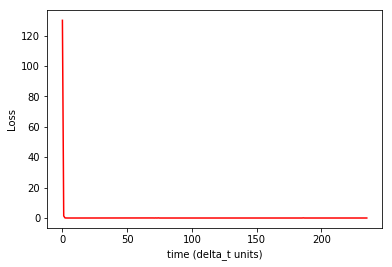

In [25]:
obs.plotLoss()

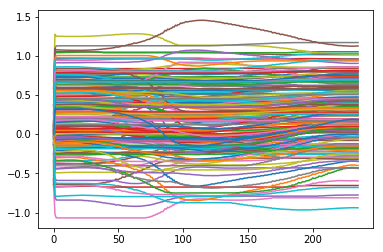

In [26]:
obs.plotParameters()

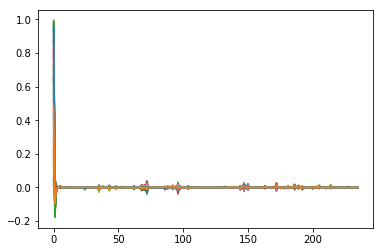

In [28]:
obs.plotVelocities()

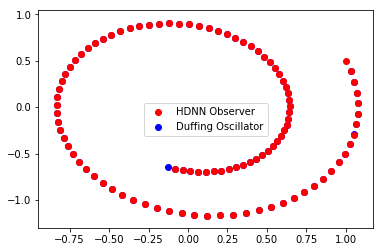

In [29]:
for p in range(len(t)-1):
    plt.scatter(t[p][0][0].cpu().numpy(),t[p][0][1].cpu().numpy(), color='r')
    plt.scatter(labels[p][0].cpu().numpy(),labels[p][1].cpu().numpy(), color='b')
    plt.legend(['HDNN Observer','Duffing Oscillator'])

In [14]:
obs.predictor(x0)

tensor([[-2.9060, -0.0562]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

# Learning a vectorial field

First, generate a dataset of trajectories from randomly sampled initial conditions

In [133]:
def generateTrajectory(duration, npoints, dynamics):
    osc = dynamics 
    t = torch.linspace(0, duration, npoints)
    xi0 = torch.Tensor(np.random.randint(-15, 15, 2)).to(device)
    func = osc.forward
    return odeint(func,xi0,t)

In [134]:
def generateDSet(n_trajectories, n_points, duration, dynamics):
    dset = []
    for n in range(n_trajectories):
        d = generateTrajectory(duration, n_points, dynamics) 
        dset.append(d)
    return dset

In [265]:
dynamics = duffingOscillator(2,0.5,0.5,0.2)
dset = generateDSet(1, 60, 5, dynamics)

Idea: learn some samples of state trajectories of the same dynamical system from random initial conditions. Try to extrapolate some kind of vectorial field

In [266]:
obs = HDNN_Observer([2,36,2],'MLP',[1,2,0], 1, None, False, 'cpu')
sols = []
for i, traj in enumerate(dset):
    x0 = traj[0].view(1,2).to(device)
    labels = traj[1:].to(device)
    sol = obs.observe(x0, labels, epoch=1, ode_t=2, ode_step=2, loss_record_interval=400)
    sols.append(sol)
    print("Currently learning trajectory number {}, initial conditions {}". format(i, x0))

odeint iter: 10 
odeint iter: 20 
odeint iter: 30 
odeint iter: 40 
odeint iter: 50 
odeint iter: 60 
odeint iter: 70 
odeint iter: 80 
odeint iter: 90 
odeint iter: 100 
odeint iter: 110 
odeint iter: 120 
odeint iter: 130 
odeint iter: 140 
odeint iter: 150 
odeint iter: 160 
odeint iter: 170 
odeint iter: 180 
odeint iter: 190 
odeint iter: 200 
odeint iter: 210 
odeint iter: 220 
odeint iter: 230 
odeint iter: 240 
odeint iter: 250 
odeint iter: 260 
odeint iter: 270 
odeint iter: 280 
odeint iter: 290 
odeint iter: 300 
odeint iter: 310 
odeint iter: 320 
odeint iter: 330 
odeint iter: 340 
odeint iter: 350 
odeint iter: 360 
odeint iter: 370 
odeint iter: 380 
odeint iter: 390 
odeint iter: 400 
odeint iter: 410 
odeint iter: 420 
odeint iter: 430 
odeint iter: 440 
odeint iter: 450 
odeint iter: 460 
odeint iter: 470 
odeint iter: 480 
odeint iter: 490 
odeint iter: 500 
odeint iter: 510 
odeint iter: 520 
odeint iter: 530 
odeint iter: 540 
odeint iter: 550 
odeint iter: 560 
o

odeint iter: 4400 
odeint iter: 4410 
odeint iter: 4420 
odeint iter: 4430 
odeint iter: 4440 
odeint iter: 4450 
odeint iter: 4460 
odeint iter: 4470 
odeint iter: 4480 
odeint iter: 4490 
odeint iter: 4500 
odeint iter: 4510 
odeint iter: 4520 
odeint iter: 4530 
odeint iter: 4540 
odeint iter: 4550 
odeint iter: 4560 
odeint iter: 4570 
odeint iter: 4580 
odeint iter: 4590 
odeint iter: 4600 
odeint iter: 4610 
odeint iter: 4620 
odeint iter: 4630 
odeint iter: 4640 
odeint iter: 4650 
odeint iter: 4660 
odeint iter: 4670 
odeint iter: 4680 
odeint iter: 4690 
odeint iter: 4700 
odeint iter: 4710 
odeint iter: 4720 
odeint iter: 4730 
odeint iter: 4740 
odeint iter: 4750 
odeint iter: 4760 
odeint iter: 4770 
odeint iter: 4780 
odeint iter: 4790 
odeint iter: 4800 
odeint iter: 4810 
odeint iter: 4820 
odeint iter: 4830 
odeint iter: 4840 
odeint iter: 4850 
odeint iter: 4860 
odeint iter: 4870 
odeint iter: 4880 
odeint iter: 4890 
odeint iter: 4900 
odeint iter: 4910 
odeint iter:

odeint iter: 8750 
odeint iter: 8760 
odeint iter: 8770 
odeint iter: 8780 
odeint iter: 8790 
odeint iter: 8800 
odeint iter: 8810 
odeint iter: 8820 
odeint iter: 8830 
odeint iter: 8840 
odeint iter: 8850 
odeint iter: 8860 
odeint iter: 8870 
odeint iter: 8880 
odeint iter: 8890 
odeint iter: 8900 
odeint iter: 8910 
odeint iter: 8920 
odeint iter: 8930 
odeint iter: 8940 
odeint iter: 8950 
odeint iter: 8960 
odeint iter: 8970 
odeint iter: 8980 
odeint iter: 8990 
odeint iter: 9000 
odeint iter: 9010 
odeint iter: 9020 
odeint iter: 9030 
odeint iter: 9040 
odeint iter: 9050 
odeint iter: 9060 
odeint iter: 9070 
odeint iter: 9080 
odeint iter: 9090 
odeint iter: 9100 
odeint iter: 9110 
odeint iter: 9120 
odeint iter: 9130 
odeint iter: 9140 
odeint iter: 9150 
odeint iter: 9160 
odeint iter: 9170 
odeint iter: 9180 
odeint iter: 9190 
odeint iter: 9200 
odeint iter: 9210 
odeint iter: 9220 
odeint iter: 9230 
odeint iter: 9240 
odeint iter: 9250 
odeint iter: 9260 
odeint iter:

odeint iter: 17000 
odeint iter: 17010 
odeint iter: 17020 
odeint iter: 17030 
odeint iter: 17040 
odeint iter: 17050 
odeint iter: 17060 
odeint iter: 17070 
odeint iter: 17080 
odeint iter: 17090 
odeint iter: 17100 
odeint iter: 17110 
odeint iter: 17120 
odeint iter: 17130 
odeint iter: 17140 
odeint iter: 17150 
odeint iter: 17160 
odeint iter: 17170 
odeint iter: 17180 
odeint iter: 17190 
odeint iter: 17200 
odeint iter: 17210 
odeint iter: 17220 
odeint iter: 17230 
odeint iter: 17240 
odeint iter: 17250 
odeint iter: 17260 
odeint iter: 17270 
odeint iter: 17280 
odeint iter: 17290 
odeint iter: 17300 
odeint iter: 17310 
odeint iter: 17320 
odeint iter: 17330 
odeint iter: 17340 
odeint iter: 17350 
odeint iter: 17360 
odeint iter: 17370 
odeint iter: 17380 
odeint iter: 17390 
odeint iter: 17400 
odeint iter: 17410 
odeint iter: 17420 
odeint iter: 17430 
odeint iter: 17440 
odeint iter: 17450 
odeint iter: 17460 
odeint iter: 17470 
odeint iter: 17480 
odeint iter: 17490 


# Vec field plot

In [70]:
def calculateComponents(x0, x1):
    return x1[0] - x0[0], x1[1] - x0[1]

In [71]:
mh = genpoints(-2, 2, -2, 2, 15)

In [72]:
obs.predictor(mh[0].view(1,2))

tensor([[-1.9123, -0.7884]], device='cuda:0', grad_fn=<AddmmBackward>)

In [73]:
U, V = [], []
for point in mh:
        un, vn = calculateComponents(point, obs.predictor(point.view(1,2)).flatten())
        U.append(un)
        V.append(vn)

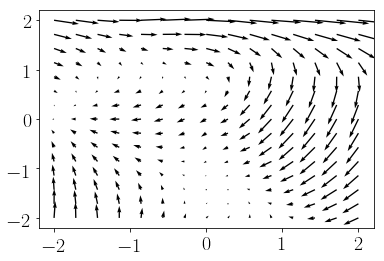

In [74]:
plt.quiver([p[0].detach().cpu() for p in mh], [p[1].detach().cpu() for p in mh], \
           [u.detach().cpu() for u in U], [v.detach().cpu() for v in V])

In [75]:
labels

tensor([[-1.4077,  0.2846],
        [-1.3661,  0.4535],
        [-1.3068,  0.5994],
        ...,
        [ 0.0230, -1.0900],
        [-0.1004, -1.1104],
        [-0.2265, -1.1383]], device='cuda:0')

In [106]:
tmax, t_trans = 1, 0
omega = 1.4
gamma, delta = 0.39, 0.1
dt_per_period = 40

In [107]:
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega)
x, xdot = X.T

In [108]:
x

array([2.        , 2.18299328, 2.26695567, 2.23881984, 2.10435936,
       1.88570651, 1.61244977, 1.31217825, 1.00489   ])

In [109]:
U, V = [], []
t = torch.linspace(0,1/25,2)
for point in mh:
        x0, v0 = point.cpu()
        t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega)
        x, xdot = X.T
        x, xdot = torch.Tensor(x).to(device), torch.Tensor(xdot).to(device)
        sol = torch.stack((x, xdot), 0)
        un, vn = calculateComponents(point, sol)
        U.append(un)
        V.append(vn)

ValueError: only one element tensors can be converted to Python scalars

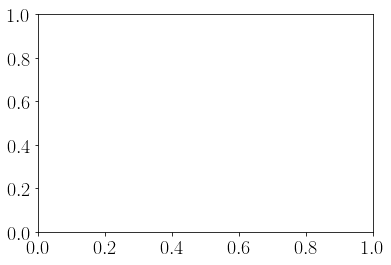

In [110]:
plt.quiver([p[0].detach().cpu() for p in mh], [p[1].detach().cpu() for p in mh], \
           [u.detach().cpu() for u in U], [v.detach().cpu() for v in V])